use this to recovery recently execute cell's code (in case any other cells randomly blank out

_ih[-100:]

In [1]:
import json # library to handle JSON files
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import urllib

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 

import pydotplus

# import various machine learning tools
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

#import model evaluation tools
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import itertools

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import os

print('Libraries imported.')

Libraries imported.


### Get data from Foursquare

In [2]:
frsq_file_dir = 'https://raw.githubusercontent.com/zenterfield/Coursera_Capstone/master/Foursquare_JSONs/'
local_frsq_dir = '/home/b/Projects/Coursera_Capstone/Foursquare_JSONs/'

In [3]:
# @hidden_cell

CLIENT_ID = 'FVEO2VGJAPTJKL0ZATZQDB5EI40JXCJH20IBSAX21AYO3U5C' # your Foursquare ID
CLIENT_SECRET = 'JAWZVIQOO510LLT3UDZTVEEHTGOVI0FQJGRWYIMVYJWKRTYP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [4]:
address = 'Brandon, FL'
search_radius = 7.500 #in kilometers

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brandon, Fl are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brandon, Fl are 27.937801, -82.2859247.


In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius, venue_section = 'food'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius*1000, 
            LIMIT,
            venue_section
            )
            
        # make the GET request (if downloading list json directly)
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # make the GET request (if using pre-downloaded list json)
        venues_url = frsq_file_dir + 'brandonFL_7.5k_food_venues_' + '20190712T2145' + '.json?raw=true'
        results = requests.get(venues_url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id'])
            for v in results]
            )

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue', 
                    'Venue_Latitude', 
                    'Venue_Longitude', 
                    'Venue_Category',
                    'Venue_ID']
    
    return(nearby_venues)

In [6]:
LIMIT = 500

nearby_venues = getNearbyVenues(   names = pd.Series(data="Brandon, FL"),
                                    latitudes = pd.Series(data=latitude),
                                    longitudes = pd.Series(data=longitude),
                                    radius = search_radius
                            )

print('Done!')

Done!


In [7]:
print(nearby_venues.shape)
nearby_venues.head()

(100, 5)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_ID
0,Moreno Bakery,27.936403,-82.295102,Bakery,4c051afef423a593f376d216
1,Thai legacy,27.938569,-82.285760,Thai Restaurant,5171cd8a498e616e54b37189
2,Babe's Pizza,27.938668,-82.293586,Pizza Place,4b7876ebf964a52026d02ee3
3,Taste Of Berlin,27.934251,-82.291767,German Restaurant,4e8f920f550342b5a3e1cce1
4,Pho Viet,27.938097,-82.301004,Vietnamese Restaurant,5261c02811d233a4c6d5e0b9


In [8]:
for ind in np.arange(nearby_venues.shape[0]):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            nearby_venues.at[ind, 'Venue_ID'], 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION )
    target_file = local_frsq_dir + nearby_venues.at[ind, 'Venue_ID'] + '.json'
    
    #use if relying on pre-downloaded venue details
    try:
        os.path.getsize(target_file)
    except:
        urllib.request.urlretrieve(url, target_file)
    venue_json = target_file 
    with open(venue_json) as json_file:
        data = json.load(json_file)
        nearby_venues.at[ind, 'Venue Likes'] = data["response"]['venue']['likes']['count']
        nearby_venues.at[ind, 'Venue Rating'] = data["response"]['venue']['rating']
        nearby_venues.at[ind, 'Venue Signals'] = data["response"]['venue']['ratingSignals']
        try:
            nearby_venues.at[ind, 'Venue Price'] = data["response"]['venue']['price']['tier']
        except:
            nearby_venues.at[ind, 'Venue Price'] = None
    
    #use if downloading venue details directly
    #data = requests.get(url).json() 
    #nearby_venues.at[ind, 'Likes'] = data["response"]['venue']['likes']['count']
    #nearby_venues.at[ind, 'Rating'] = data["response"]['venue']['rating']

In [9]:
print(nearby_venues.shape)
nearby_venues.head()

(100, 9)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_ID,Venue Likes,Venue Rating,Venue Signals,Venue Price
0,Moreno Bakery,27.936403,-82.295102,Bakery,4c051afef423a593f376d216,140.0,9.2,195.0,1.0
1,Thai legacy,27.938569,-82.285760,Thai Restaurant,5171cd8a498e616e54b37189,8.0,8.4,12.0,2.0
2,Babe's Pizza,27.938668,-82.293586,Pizza Place,4b7876ebf964a52026d02ee3,34.0,8.8,57.0,1.0
3,Taste Of Berlin,27.934251,-82.291767,German Restaurant,4e8f920f550342b5a3e1cce1,23.0,8.5,34.0,2.0
4,Pho Viet,27.938097,-82.301004,Vietnamese Restaurant,5261c02811d233a4c6d5e0b9,25.0,8.7,38.0,2.0


In [10]:
og_venue_data = nearby_venues.copy(deep=True)

#nearby_venues.pivot_table(index = 'Venue_Category', values = 'Venue Rating', aggfunc='count')

In [11]:
#merge similar venue categories to simplify later analysis

nearby_venues.loc[og_venue_data['Venue_Category'] == "American Restaurant", 'Venue_Category'] = "American"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Diner", 'Venue_Category'] = "American"
nearby_venues.loc[og_venue_data['Venue_Category'] == "New American Restaurant", 'Venue_Category'] = "American"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Seafood Restaurant", 'Venue_Category'] = "American"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Steakhouse", 'Venue_Category'] = "American"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Asian Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Chinese Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Indian Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Japanese Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Mongolian Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Pakistani Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Sushi Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Thai Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Vietnamese Restaurant", 'Venue_Category'] = "Asian"
nearby_venues.loc[og_venue_data['Venue_Category'] == "German Restaurant", 'Venue_Category'] = "European"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Greek Restaurant", 'Venue_Category'] = "European"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Italian Restaurant", 'Venue_Category'] = "European"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Fast Food Restaurant", 'Venue_Category'] = "Fast"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Pizza Place", 'Venue_Category'] = "Fast"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Sandwich Place", 'Venue_Category'] = "Joints"
nearby_venues.loc[og_venue_data['Venue_Category'] == "BBQ Joint", 'Venue_Category'] = "Joints"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Burger Joint", 'Venue_Category'] = "Joints"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Fried Chicken Joint", 'Venue_Category'] = "Joints"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Hot Dog Joint", 'Venue_Category'] = "Joints"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Wings Joint", 'Venue_Category'] = "Joints"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Cajun / Creole Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Caribbean Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Cuban Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Latin American Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Mexican Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "South American Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Tex-Mex Restaurant", 'Venue_Category'] = "Latin"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Breakfast Spot", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Bakery", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Café", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Donut Shop", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Food Court", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Hawaiian Restaurant", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Restaurant", 'Venue_Category'] = "Other"
nearby_venues.loc[og_venue_data['Venue_Category'] == "Salad Place", 'Venue_Category'] = "Other"

nearby_venues['Venue_Category'].unique()

nearby_venues.pivot_table(index = 'Venue_Category', values = 'Venue Rating', aggfunc='count')

,Venue Rating
Venue_Category,
American,19
Asian,18
European,5
Fast,12
Joints,16
Latin,14
Other,16


In [12]:
nearby_venues['Venue LikesRatio'] = nearby_venues['Venue Likes'] / nearby_venues['Venue Signals']
nearby_venues.describe()

,Venue_Latitude,Venue_Longitude,Venue Likes,Venue Rating,Venue Signals,Venue Price,Venue LikesRatio
count,100.000000,100.000000,100.000000,100.000000,100.000,97.000000,100.000000
mean,27.929502,-82.303065,53.660000,8.206000,77.990,1.680412,0.680101
std,0.015227,0.022085,45.307751,0.467277,63.241,0.604607,0.103344
min,27.891417,-82.339880,3.000000,7.200000,3.000,1.000000,0.363636
25%,27.923497,-82.321867,21.000000,7.800000,32.750,1.000000,0.618702
50%,27.936660,-82.310809,37.500000,8.200000,53.500,2.000000,0.693980
75%,27.938170,-82.285681,79.500000,8.600000,115.000,2.000000,0.733962
max,27.982069,-82.250799,203.000000,9.200000,284.000,4.000000,1.000000


### Get geo data for Census Tracts

In [13]:
tract_shapes_dir = 'https://raw.githubusercontent.com/zenterfield/Coursera_Capstone/master/ACS17_Shapefiles_perCensusTractFL/'
local_shapes_dir = '/home/b/Projects/Coursera_Capstone/ACS17_Shapefiles_perCensusTractFL/'

In [14]:
#!conda install -c conda-forge pyshp --yes

In [15]:
import shapefile

print('Libraries imported.')

Libraries imported.


In [16]:
shp_url = local_shapes_dir + "tl_2017_12_tract.shp"
sf = shapefile.Reader(shp_url)

In [17]:
shapes = sf.shapes()
fields = sf.fields
records = sf.records()

In [18]:
print("Shapes contains " + str(len(shapes)))
print("Records contains " + str(len(records)))

Shapes contains 4245
Records contains 4245


In [19]:
for field in fields:
    print(field)

('DeletionFlag', 'C', 1, 0)
['STATEFP', 'C', 2, 0]
['COUNTYFP', 'C', 3, 0]
['TRACTCE', 'C', 6, 0]
['GEOID', 'C', 11, 0]
['NAME', 'C', 7, 0]
['NAMELSAD', 'C', 20, 0]
['MTFCC', 'C', 5, 0]
['FUNCSTAT', 'C', 1, 0]
['ALAND', 'N', 14, 0]
['AWATER', 'N', 14, 0]
['INTPTLAT', 'C', 11, 0]
['INTPTLON', 'C', 12, 0]


In [20]:
geo_headers = []
for field in fields[1:20]:
    geo_headers.append(field[0])
    
geo_headers

['STATEFP',
 'COUNTYFP',
 'TRACTCE',
 'GEOID',
 'NAME',
 'NAMELSAD',
 'MTFCC',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON']

In [21]:
tracts_geo = pd.DataFrame(records)

In [22]:
tracts_geo.columns = geo_headers

tracts_geo.drop('STATEFP', axis=1, inplace = True)
tracts_geo.drop('COUNTYFP', axis=1, inplace = True)
tracts_geo.drop('TRACTCE', axis=1, inplace = True)
tracts_geo.drop('NAMELSAD', axis=1, inplace = True)
tracts_geo.drop('MTFCC', axis=1, inplace = True)
tracts_geo.drop('FUNCSTAT', axis=1, inplace = True)
tracts_geo.drop('ALAND', axis=1, inplace = True)
tracts_geo.drop('AWATER', axis=1, inplace = True)
tracts_geo.drop('INTPTLAT', axis=1, inplace = True)
tracts_geo.drop('INTPTLON', axis=1, inplace = True)

print(tracts_geo.shape)
#tracts_geo.sort_values(by = 'GEOID').head()
tracts_geo.head()

(4245, 2)


,GEOID,NAME
0,12011020411,204.11
1,12011010102,101.02
2,12011110402,1104.02
3,12011010304,103.04
4,12011010401,104.01


In [23]:
for ind in np.arange(tracts_geo.shape[0]):
    tracts_geo.at[ind, 'lt_min'] = shapes[ind].bbox[1]
    tracts_geo.at[ind, 'lt_max'] = shapes[ind].bbox[3]
    tracts_geo.at[ind, 'lt_avg'] = (shapes[ind].bbox[1] + shapes[ind].bbox[3]) / 2
    tracts_geo.at[ind, 'lg_min'] = shapes[ind].bbox[0]
    tracts_geo.at[ind, 'lg_max'] = shapes[ind].bbox[2]
    tracts_geo.at[ind, 'lg_avg'] = (shapes[ind].bbox[0] + shapes[ind].bbox[2]) / 2

In [24]:
print(tracts_geo.shape)
#tracts_geo.sort_values(by = 'GEOID').head()
tracts_geo.head()

(4245, 8)


,GEOID,NAME,lt_min,lt_max,lt_avg,lg_min,lg_max,lg_avg
0,12011020411,204.11,26.208354,26.229926,26.219140,-80.273981,-80.252293,-80.263137
1,12011010102,101.02,26.291376,26.305133,26.298254,-80.095183,-80.080180,-80.087682
2,12011110402,1104.02,25.971875,25.981895,25.976885,-80.247088,-80.229593,-80.238340
3,12011010304,103.04,26.297277,26.304874,26.301075,-80.121585,-80.105362,-80.113473
4,12011010401,104.01,26.317782,26.327824,26.322803,-80.170149,-80.152669,-80.161409


In [25]:
from math import sin, cos, sqrt, atan2, radians

def dist_latlong(lat_a, lon_a, lat_b, lon_b):

    # approximate radius of earth in km
    R_earth = 6373.0

    lat1 = radians(lat_a)
    lon1 = radians(lon_a)
    lat2 = radians(lat_b)
    lon2 = radians(lon_b)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R_earth * c
    
    return(distance)

In [26]:
for ind in np.arange(tracts_geo.shape[0]):
    #distance from center of Brandon, FL to center of census tract
    distance = dist_latlong(latitude, longitude, tracts_geo.at[ind, 'lt_avg'], tracts_geo.at[ind, 'lg_avg'])
    tracts_geo.at[ind, 'dist_from_BFL'] = distance

In [27]:
print(tracts_geo.shape)
#tracts_geo.sort_values(by = 'GEOID').head()
tracts_geo.head()

(4245, 9)


,GEOID,NAME,lt_min,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL
0,12011020411,204.11,26.208354,26.229926,26.219140,-80.273981,-80.252293,-80.263137,276.895281
1,12011010102,101.02,26.291376,26.305133,26.298254,-80.095183,-80.080180,-80.087682,283.925759
2,12011110402,1104.02,25.971875,25.981895,25.976885,-80.247088,-80.229593,-80.238340,297.953565
3,12011010304,103.04,26.297277,26.304874,26.301075,-80.121585,-80.105362,-80.113473,281.768745
4,12011010401,104.01,26.317782,26.327824,26.322803,-80.170149,-80.152669,-80.161409,276.572923


In [28]:
radius_margin = 1/5

tracts_geo = tracts_geo[tracts_geo['dist_from_BFL'] < (search_radius * (1 + radius_margin) )]
#slightly wider radius to so venues located on edge of original radius are given 
#access to tracts to tracts just barely outside that original radius

In [29]:
print(tracts_geo.shape)
#tracts_geo.sort_values(by = 'dist_from_BFL').head()
tracts_geo.head()

(51, 9)


,GEOID,NAME,lt_min,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL
1141,12057013205,132.05,27.908274,27.933710,27.920992,-82.252775,-82.219487,-82.236131,5.238458
1146,12057013208,132.08,27.872617,27.898935,27.885776,-82.243857,-82.188926,-82.216391,8.955217
1147,12057013305,133.05,27.893614,27.923350,27.908482,-82.269320,-82.243857,-82.256588,4.352897
1148,12057013415,134.15,27.857275,27.876921,27.867098,-82.269304,-82.241155,-82.255229,8.423246
1162,12057013314,133.14,27.893605,27.908296,27.900951,-82.293983,-82.269234,-82.281609,4.120768


### Get demographic data for Census tracts

In [30]:
tract_demos_dir = 'https://raw.githubusercontent.com/zenterfield/Coursera_Capstone/master/ACS17_SexByAge_B010001_perCensusTract_FL/'
local_demos_dir = '/home/b/Projects/Coursera_Capstone/ACS17_SexByAge_B010001_perCensusTract_FL/'

In [31]:
demos_df = pd.read_csv(tract_demos_dir + 'Hawaiian_ACS_17_5YR_B01001E_with_ann.csv', nrows = 1)
demos_df.columns = demos_df.iloc[0]
demos_df.drop(demos_df.index[0], inplace=True)
print(demos_df.shape)
demos_df.head(1)

(0, 65)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Male:,Margin of Error; Male:,Estimate; Male: - Under 5 years,Margin of Error; Male: - Under 5 years,Estimate; Male: - 5 to 9 years,...,Estimate; Female: - 45 to 54 years,Margin of Error; Female: - 45 to 54 years,Estimate; Female: - 55 to 64 years,Margin of Error; Female: - 55 to 64 years,Estimate; Female: - 65 to 74 years,Margin of Error; Female: - 65 to 74 years,Estimate; Female: - 75 to 84 years,Margin of Error; Female: - 75 to 84 years,Estimate; Female: - 85 years and over,Margin of Error; Female: - 85 years and over


In [32]:
other_files = [ 'Hawaiian_ACS_17_5YR_B01001E_with_ann.csv',
                'AmIndian_ACS_17_5YR_B01001C_with_ann.csv', 
                'Other_ACS_17_5YR_B01001F_with_ann.csv', 
                '2+_ACS_17_5YR_B01001G_with_ann.csv'
              ]

major_files = [ 'Asian_ACS_17_5YR_B01001D_with_ann.csv', 
                'Black_ACS_17_5YR_B01001B_with_ann.csv', 
                'Hisp_ACS_17_5YR_B01001I_with_ann.csv', 
                #'WhiteNonHisp_ACS_17_5YR_B01001H_with_ann.csv', 
                'White_ACS_17_5YR_B01001A_with_ann.csv'
              ]

for filename in other_files:
    next_df = pd.read_csv(tract_demos_dir + filename, skiprows=1)
    race_eth_title = ': ' + filename[0:filename.index('_')]
    print(race_eth_title)
    next_df['Id'] = race_eth_title
    demos_df = demos_df.append(next_df, sort=False)

demos_df.rename(columns={'Id':'Race_Eth', 'Id2':'GEOID'}, inplace=True)

print(demos_df.shape)
#demos_df.head()

print(demos_df.pivot_table(values='GEOID', index='Race_Eth', aggfunc='count'))

print("Grouping now...")
starttime = time.time()

demos_df.loc[demos_df['Race_Eth'] == ": Hawaiian", 'Race_Eth'] = ": Other"
demos_df.loc[demos_df['Race_Eth'] == ": 2+", 'Race_Eth'] = ": Other"
demos_df.loc[demos_df['Race_Eth'] == ": AmIndian", 'Race_Eth'] = ": Other"

column_order = demos_df.columns

demos_df = demos_df.groupby(by=['Race_Eth', 'GEOID'], group_keys = False).sum()

demos_df = demos_df.pivot_table(index=['Race_Eth', 'GEOID'], aggfunc = 'sum').reset_index()

print(str(time.time()-starttime) + " seconds later")
print("Grouped, now resetting column order")

demos_df = demos_df.reindex(columns = column_order)

print(demos_df.shape)

for filename in major_files:
    next_df = pd.read_csv(tract_demos_dir + filename, skiprows=1)
    next_df.rename(columns={'Id':'Race_Eth', 'Id2':'GEOID'}, inplace=True)
    race_eth_title = ': ' + filename[0:filename.index('_')]
    print(race_eth_title)
    next_df['Race_Eth'] = race_eth_title
    demos_df = demos_df.append(next_df, sort=False)

demos_df.drop('Geography', axis=1, inplace=True)
print(demos_df.shape)
demos_df.tail(1)

race_count = demos_df['Race_Eth'].nunique()

: Hawaiian
: AmIndian
: Other
: 2+
(16980, 65)
0           GEOID
Race_Eth         
: 2+         4245
: AmIndian   4245
: Hawaiian   4245
: Other      4245
Grouping now...
30.8677179813385 seconds later
Grouped, now resetting column order
(4245, 65)
: Asian
: Black
: Hisp
: White
(21225, 64)


In [33]:
#drop Estimate columns
int = len(demos_df.columns)-1
while int > 2:
    demos_df.drop(demos_df.columns[int], axis=1, inplace=True)
    int = int - 2
print(demos_df.shape)
demos_df.head()

(21225, 33)


,Race_Eth,GEOID,Estimate; Total:,Estimate; Male:,Estimate; Male: - Under 5 years,Estimate; Male: - 5 to 9 years,Estimate; Male: - 10 to 14 years,Estimate; Male: - 15 to 17 years,Estimate; Male: - 18 and 19 years,Estimate; Male: - 20 to 24 years,...,Estimate; Female: - 18 and 19 years,Estimate; Female: - 20 to 24 years,Estimate; Female: - 25 to 29 years,Estimate; Female: - 30 to 34 years,Estimate; Female: - 35 to 44 years,Estimate; Female: - 45 to 54 years,Estimate; Female: - 55 to 64 years,Estimate; Female: - 65 to 74 years,Estimate; Female: - 75 to 84 years,Estimate; Female: - 85 years and over
0,: Other,12001000200,286,110,0,0,18,5,31,14,...,0,126,0,0,26,10,0,0,0,0
1,: Other,12001000301,185,107,21,0,0,11,0,16,...,0,12,29,0,0,9,12,0,0,0
2,: Other,12001000302,215,92,0,46,16,0,0,4,...,0,23,0,14,24,2,21,0,0,0
3,: Other,12001000400,583,265,28,47,21,0,65,0,...,10,0,32,0,18,0,40,0,0,0
4,: Other,12001000500,174,89,0,17,0,0,0,5,...,0,68,0,0,17,0,0,0,0,0


In [34]:
print(race_count)

5


In [35]:
pivot_demos = demos_df.pivot(index='GEOID', columns='Race_Eth')
cols = pd.Series(pivot_demos.columns.tolist()).apply(pd.Series).sum(axis=1)
cols = cols.str.replace('Estimate; ', '')
cols = cols.str.replace('- ', '')
cols = cols.str.replace(':: ', ':')
cols = cols.str.replace(': ', ':')
cols = cols.str.replace(' to ', '-')
cols = cols.str.replace(' years', '')
cols = cols.str.replace(' and ', '-')
cols = cols.str.replace('Under 5', '0-4')
cols = cols.str.replace('0-4', '00-04')
cols = cols.str.replace('5-9', '05-09')
cols = cols.str.replace('over', '99')
pivot_demos.columns = cols
pivot_demos.head()

#for col in pivot_demos.columns:
    #print(col)

,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White,Male:Asian,Male:Black,Male:Hisp,Male:Other,Male:White,...,Female:75-84:Asian,Female:75-84:Black,Female:75-84:Hisp,Female:75-84:Other,Female:75-84:White,Female:85-99:Asian,Female:85-99:Black,Female:85-99:Hisp,Female:85-99:Other,Female:85-99:White
GEOID,,,,,,,,,,,,,,,,,,,,,
12001000200,225,1277,616,286,5046,111,534,241,110,2341,...,0,76,0,0,0,0,13,0,0,0
12001000301,128,1223,254,185,2313,68,571,102,107,1060,...,7,32,0,0,31,0,0,0,0,20
12001000302,179,448,336,215,1532,113,243,93,92,703,...,0,11,0,0,37,0,15,0,0,25
12001000400,72,3391,519,583,1950,21,1494,97,265,837,...,21,46,56,0,102,0,0,0,0,21
12001000500,118,927,484,174,3983,101,499,206,89,1928,...,0,0,0,0,38,0,0,0,0,96


In [36]:
# add to next age brackets of same race, identified by col index + race_count

int = 0
for col in pivot_demos.columns:
    if col.count("00-04") > 0 and col.count(":") > 0:
        toddler = int
        kid = toddler + race_count
        preteen = kid + race_count
        teen = preteen + race_count
        new_col_name = col.replace('00-04', '_00-17')
        pivot_demos[new_col_name] = pivot_demos[pivot_demos.columns[toddler]] + pivot_demos[pivot_demos.columns[kid]] + pivot_demos[pivot_demos.columns[preteen]] + pivot_demos[pivot_demos.columns[teen]]
    int = int + 1

int = 0
for col in pivot_demos.columns:
    if col.count("18-19") > 0 and col.count(":") > 0:
        late_teen = int
        early20s = late_teen + race_count
        late20s = early20s + race_count
        early30s = late20s + race_count
        new_col_name = col.replace('18-19', '_18-34')
        pivot_demos[new_col_name] = pivot_demos[pivot_demos.columns[late_teen]] + pivot_demos[pivot_demos.columns[early20s]] + pivot_demos[pivot_demos.columns[late20s]] + pivot_demos[pivot_demos.columns[early30s]]
    int = int + 1
    
int = 0
for col in pivot_demos.columns:
    if col.count("35-44") > 0 and col.count(":") > 0:
        into40s = int
        into50s = into40s + race_count
        into60s = into50s + race_count
        new_col_name = col.replace('35-44', '_35-64')
        pivot_demos[new_col_name] = pivot_demos[pivot_demos.columns[into40s]] + pivot_demos[pivot_demos.columns[into50s]] + pivot_demos[pivot_demos.columns[into60s]]
    int = int + 1
    
int = 0
for col in pivot_demos.columns:
    if col.count("65-74") > 0 and col.count(":") > 0:
        into70s = int
        into80s = into70s + race_count
        into90s = into80s + race_count
        new_col_name = col.replace('65-74', '_65-99')
        pivot_demos[new_col_name] = pivot_demos[pivot_demos.columns[into70s]] + pivot_demos[pivot_demos.columns[into80s]] + pivot_demos[pivot_demos.columns[into90s]]
    int = int + 1
    
pivot_demos.head()

,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White,Male:Asian,Male:Black,Male:Hisp,Male:Other,Male:White,...,Male:_65-99:Asian,Male:_65-99:Black,Male:_65-99:Hisp,Male:_65-99:Other,Male:_65-99:White,Female:_65-99:Asian,Female:_65-99:Black,Female:_65-99:Hisp,Female:_65-99:Other,Female:_65-99:White
GEOID,,,,,,,,,,,,,,,,,,,,,
12001000200,225,1277,616,286,5046,111,534,241,110,2341,...,0,22,0,0,0,0,127,0,0,0
12001000301,128,1223,254,185,2313,68,571,102,107,1060,...,0,23,0,0,35,11,55,0,0,154
12001000302,179,448,336,215,1532,113,243,93,92,703,...,31,9,0,7,91,0,45,0,0,102
12001000400,72,3391,519,583,1950,21,1494,97,265,837,...,0,93,10,0,93,21,174,56,0,232
12001000500,118,927,484,174,3983,101,499,206,89,1928,...,0,74,13,13,146,0,15,0,0,292


In [37]:
#remove the original age breakdown columns
pivot_demos = pivot_demos.filter(regex="^((?!.*\-.*).*)|(.*_.*)$")

pivot_demos.columns = pivot_demos.columns.str.replace('_', '')

pivot_demos.head()

,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White,Male:Asian,Male:Black,Male:Hisp,Male:Other,Male:White,...,Male:65-99:Asian,Male:65-99:Black,Male:65-99:Hisp,Male:65-99:Other,Male:65-99:White,Female:65-99:Asian,Female:65-99:Black,Female:65-99:Hisp,Female:65-99:Other,Female:65-99:White
GEOID,,,,,,,,,,,,,,,,,,,,,
12001000200,225,1277,616,286,5046,111,534,241,110,2341,...,0,22,0,0,0,0,127,0,0,0
12001000301,128,1223,254,185,2313,68,571,102,107,1060,...,0,23,0,0,35,11,55,0,0,154
12001000302,179,448,336,215,1532,113,243,93,92,703,...,31,9,0,7,91,0,45,0,0,102
12001000400,72,3391,519,583,1950,21,1494,97,265,837,...,0,93,10,0,93,21,174,56,0,232
12001000500,118,927,484,174,3983,101,499,206,89,1928,...,0,74,13,13,146,0,15,0,0,292


In [38]:
pivot_demos.to_excel("/home/b/Projects/Coursera_Capstone/pivot_demos.xlsx")

In [39]:
#aggregate by age/race thru adding the Male and Female columns for each age/race
int = 0
cols = pivot_demos.columns.values.tolist()
for col in cols:
    if col[0:4] == 'Male' and col.count(':') == 2 :
        male_col = int
        female_col = cols.index( ('Fem' + cols[male_col][1:]) ) #skipping to equivalent column
        pivot_demos[col[5:]] = pivot_demos.iloc[:, male_col] + pivot_demos.iloc[:, female_col]
    int = int + 1

#print(pivot_demos.head())

#aggregate by age thru adding the aggregated race columns for each age
int = 0 
for col in pivot_demos.columns:
    if col[0:4] != 'Male' and col[0:6] != 'Female' and col.count(':') == 1 and col.count('Asian') == 1:
        first_col = int #first column of the age/race aggregates
        last_col = first_col + (race_count-1) #number of race categories being aggregated together
        #print(pivot_demos.columns[first_col] + \' | \' + pivot_demos.columns[last_col])
        #print(pivot_demos.columns[last_col])
        colon = col.find(':')
        pivot_demos[col[:colon]] = 0
        for int_2 in range(first_col, last_col+1):
            if pivot_demos.columns[int_2].count('Hisp') == 0: #not including Hispanic counts in total as they\'re technically an ethicity and already represented in the racial groups
                pivot_demos[col[:colon]] =  pivot_demos[col[:colon]] + pivot_demos.iloc[:, int_2]
    int = int + 1

filtered_tracts = tracts_geo['GEOID'].tolist()

pivot_demos.reset_index(inplace=True)

pivot_demos = pivot_demos[pivot_demos['GEOID'].isin(filtered_tracts ) ]

pivot_demos.rename(columns={'Total':'Total:ALL'}, inplace=True)

print("Demographics: " + str(pivot_demos.shape))
print("Geographics: " + str(tracts_geo.shape))

print("Done!")
pivot_demos.head()

Demographics: (51, 81)
Geographics: (51, 9)
Done!


,GEOID,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White,Male:Asian,Male:Black,Male:Hisp,Male:Other,...,65-99:Asian,65-99:Black,65-99:Hisp,65-99:Other,65-99:White,Total:ALL,00-17,18-34,35-64,65-99
1365,12057012103,965,1710,2019,971,4221,589,932,978,484,...,18,14,120,59,304,7867,2619,2127,2726,395
1366,12057012104,13,1604,1993,1248,4709,13,590,950,633,...,0,54,162,52,611,7574,2802,1514,2541,717
1367,12057012106,361,356,1206,303,4157,168,131,628,94,...,74,20,145,0,625,5177,1245,736,2477,719
1368,12057012107,40,631,1118,493,3292,9,305,496,184,...,0,0,70,28,323,4456,995,1322,1788,351
1369,12057012108,77,473,871,244,2698,43,248,370,148,...,4,11,34,0,328,3492,953,815,1381,343


#### Cluster census tracts based on age and race demographics

In [40]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

pivot_demos_cluster = pivot_demos.copy()
pivot_demos_cluster.set_index('GEOID', inplace=True)

for col in pivot_demos_cluster.columns:
    if col != 'Total:ALL':
        pivot_demos_cluster[col] = pivot_demos_cluster[col] / pivot_demos_cluster['Total:ALL']

#pivot_demos_cluster = pivot_demos_cluster/pivot_demos_cluster['Total:ALL']
pivot_demos_cluster.drop('Total:ALL', axis=1, inplace=True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pivot_demos_cluster)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

# add clustering labels
pivot_demos_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

pivot_demos_cluster.head()

,Cluster Labels,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White,Male:Asian,Male:Black,Male:Hisp,Male:Other,...,35-64:White,65-99:Asian,65-99:Black,65-99:Hisp,65-99:Other,65-99:White,00-17,18-34,35-64,65-99
GEOID,,,,,,,,,,,,,,,,,,,,,
12057012103,0,0.122664,0.217364,0.256642,0.123427,0.536545,0.074870,0.118470,0.124317,0.061523,...,0.222702,0.002288,0.001780,0.015254,0.007500,0.038642,0.332910,0.270370,0.346511,0.050210
12057012104,0,0.001716,0.211777,0.263137,0.164774,0.621732,0.001716,0.077898,0.125429,0.083575,...,0.231186,0.000000,0.007130,0.021389,0.006866,0.080671,0.369950,0.199894,0.335490,0.094666
12057012106,1,0.069732,0.068766,0.232953,0.058528,0.802975,0.032451,0.025304,0.121306,0.018157,...,0.393471,0.014294,0.003863,0.028008,0.000000,0.120726,0.240487,0.142167,0.478462,0.138884
12057012107,2,0.008977,0.141607,0.250898,0.110637,0.738779,0.002020,0.068447,0.111311,0.041293,...,0.316203,0.000000,0.000000,0.015709,0.006284,0.072487,0.223294,0.296679,0.401257,0.078770
12057012108,2,0.022050,0.135452,0.249427,0.069874,0.772623,0.012314,0.071019,0.105956,0.042383,...,0.298396,0.001145,0.003150,0.009737,0.000000,0.093929,0.272910,0.233391,0.395475,0.098225


### calculate the "concentration factor" as the ratio of the tract's proportion for each subpopulation vs the tract's proportion for total population

##### I think I re-invented the wheel here and basically tried to calculate a quasi-Z-score

pivot_demos = pivot_demos.astype('float64')
pivot_demos['GEOID'] = pivot_demos['GEOID'].astype('int')

pivot_demos_concs = pivot_demos.copy()

cols = pd.Series(pivot_demos_concs.columns.tolist()).apply(pd.Series).sum(axis=1)

for col in np.arange(pivot_demos_concs.shape[1]):
    total_col_sum = pivot_demos_concs['Total:ALL'].sum()
    if col > 0 and cols[col] != 'Total:ALL' and cols[col] != 'dist_from_BFL':
        column_sum = pivot_demos_concs[cols[col]].sum()
        for row in np.arange(pivot_demos_concs.shape[0]):
            sub_tract = pivot_demos_concs.iat[row, col]
            total_tract = pivot_demos_concs[['Total:ALL']].iat[row, 0]
            sub_all = column_sum
            total_all = total_col_sum
            
            if total_all == 0:
                print(str(cols[col]) + " (" + str(sub_tract) + " / " + str(total_tract) + ") / (" + str(sub_all) + " / " + str(total_all) + "))-1)")
            
            try:
                pivot_demos_concs.iat[row, col] = ((sub_tract / total_tract) / (sub_all / total_all))-1
                #subtract 1, makes >0 mean more likely than general, <0 less likely than general
                #necessary b/c distance factor below shouldn't change more vs. less likely when multiplied
                #without subtracting 1, >1.0 meant more likely than general, <1.0 (but >=0) less likely than general
            except ZeroDivisionError:
                pivot_demos_props.iat[row, col] = 0.0
                
pivot_demos_concs['Total:ALL'] = 0

for col in np.arange(cols.size):
    if cols[col] != 'GEOID':
        cols[col] = cols[col] + ' conc'
    
pivot_demos_concs.columns = cols

print(pivot_demos_concs.shape)
pivot_demos_concs.head() 

pivot_demos_concs.describe()

### Combine geographic data with demographic data

In [365]:
tracts_geo['GEOID'] = pd.to_numeric(tracts_geo['GEOID'])

print(tracts_geo['GEOID'].dtype)
print(pivot_demos['GEOID'].dtype)

#geo_n_counts = tracts_geo.set_index('GEOID').join(pivot_demos.set_index('GEOID'), on='GEOID')
#tract_data = geo_n_counts.join(pivot_demos_concs.set_index('GEOID'), on='GEOID')

tract_data = tracts_geo.join(pivot_demos_cluster[['Cluster Labels']], on='GEOID')
tract_data = tract_data.join(pivot_demos.set_index('GEOID'), on='GEOID')

#tract_data.reset_index(inplace=True)

tract_data.sort_values(by='GEOID', inplace=True)
tract_data.reset_index(inplace=True, drop=True)
print(tract_data.shape)
tract_data.head()

int64
int64
(51, 90)


,GEOID,NAME,lt_min,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL,Cluster Labels,...,65-99:Asian,65-99:Black,65-99:Hisp,65-99:Other,65-99:White,Total:ALL,00-17,18-34,35-64,65-99
0,12057012103,121.03,27.967351,28.002210,27.984780,-82.360434,-82.326604,-82.343519,7.702160,0,...,18,14,120,59,304,7867,2619,2127,2726,395
1,12057012104,121.04,27.972858,28.006342,27.989600,-82.327295,-82.302271,-82.314783,6.421365,0,...,0,54,162,52,611,7574,2802,1514,2541,717
2,12057012106,121.06,27.982542,28.024872,28.003707,-82.277774,-82.236065,-82.256919,7.865005,1,...,74,20,145,0,625,5177,1245,736,2477,719
3,12057012107,121.07,27.976475,28.009397,27.992936,-82.302422,-82.285853,-82.294138,6.185505,2,...,0,0,70,28,323,4456,995,1322,1788,351
4,12057012108,121.08,27.979421,28.012471,27.995946,-82.286199,-82.277654,-82.281926,6.479375,2,...,4,11,34,0,328,3492,953,815,1381,343


In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(   tract_data['lt_avg'], 
                                     tract_data['lg_avg'], 
                                     tract_data['GEOID'], 
                                     tract_data['Cluster Labels'],
                                  ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

#val_cols = tract_data.columns[10:]
val_cols = [
            '00-17', '18-34', '35-64', '65-99',
            'Total:Asian', 'Total:Black', 'Total:Hisp', 'Total:Other', 'Total:White',
           ]

cluster_desc = pivot_demos_cluster.pivot_table(index='Cluster Labels', values=val_cols, aggfunc = 'mean')
cluster_desc.reset_index(inplace=True)

rainbow_ser = pd.Series(rainbow)
cluster_desc['Color'] = rainbow_ser[cluster_desc['Cluster Labels']]

cluster_desc

,Cluster Labels,00-17,18-34,35-64,65-99,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White,Color
0,0,0.250873,0.308770,0.365689,0.074668,0.052783,0.265232,0.284223,0.136439,0.545547,blue
1,1,0.228881,0.182450,0.436974,0.151695,0.030633,0.070283,0.198253,0.046591,0.852493,green
2,2,0.224143,0.224505,0.421505,0.129847,0.046918,0.149538,0.217725,0.078767,0.724777,red
3,3,0.245803,0.264642,0.364394,0.125162,0.017900,0.177926,0.439385,0.125175,0.678999,cyan


Race appears to be a bigger dividing factor than age; children were distributed consistently across each cluster

* Blue is a concentrated area of black residents, with a slight concentration of young adults as well and very few elderly residents
* Green are concentrated areas of white residents and very few black or 'Other' residents, with a slight concentration of middle-aged adults as well
* Red are least unique, with no real concentration of any age bracket or recial group
* Cyan are concentrated areas of hispanic residents and very few Asian residents, with no real concentration as far as age brackets

### Cross-join tracts to venues

In [356]:
tract_clusters = tracts_geo.join(pivot_demos_cluster[['Cluster Labels']], on='GEOID').copy()
print(tract_clusters.shape)
#tract_clusters.head()

tract_clusters['Cluster Labels'] = "Cluster " + tract_clusters['Cluster Labels'].apply(str)
tract_cluster_OH = tract_clusters.drop('Cluster Labels', axis=1)
tract_cluster_OH = pd.concat([tract_cluster_OH, pd.get_dummies(tract_clusters['Cluster Labels'])], axis=1)

tract_clusters = tract_cluster_OH

tract_columns = tract_clusters.columns

for cluster_int in np.arange(kclusters):
    rename_col = "Cluster " + str(cluster_int)
    tract_columns = tract_columns.str.replace(rename_col, rainbow[cluster_int] + " Cluster")

tract_clusters.columns = tract_columns

print(tract_clusters.shape)
tract_clusters.head()

(51, 10)
(51, 13)


,GEOID,NAME,lt_min,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL,blue Cluster,green Cluster,red Cluster,cyan Cluster
1141,12057013205,132.05,27.908274,27.933710,27.920992,-82.252775,-82.219487,-82.236131,5.238458,0,0,1,0
1146,12057013208,132.08,27.872617,27.898935,27.885776,-82.243857,-82.188926,-82.216391,8.955217,0,1,0,0
1147,12057013305,133.05,27.893614,27.923350,27.908482,-82.269320,-82.243857,-82.256588,4.352897,0,1,0,0
1148,12057013415,134.15,27.857275,27.876921,27.867098,-82.269304,-82.241155,-82.255229,8.423246,0,1,0,0
1162,12057013314,133.14,27.893605,27.908296,27.900951,-82.293983,-82.269234,-82.281609,4.120768,0,1,0,0


In [370]:
full_tract_data = tract_data.copy()
tract_data = tract_clusters.copy()

nearby_venues['key'] = 0
tract_data['key'] = 0

venuesXtracts = nearby_venues.merge(tract_data, how='outer', on='key')

venuesXtracts.rename(columns={'key':'dist_ven_tract'}, inplace=True)
venuesXtracts['dist_ven_tract'] = venuesXtracts['dist_ven_tract'].astype(float)

#print(venuesXtracts.dtypes)

for ind in np.arange(venuesXtracts.shape[0]):
    #distance from venue to center of census tract
    distance = dist_latlong(    venuesXtracts.at[ind, 'Venue_Latitude'], 
                                venuesXtracts.at[ind, 'Venue_Longitude'], 
                                venuesXtracts.at[ind, 'lt_avg'], 
                                venuesXtracts.at[ind, 'lg_avg']
                                             )
    venuesXtracts.at[ind, 'dist_ven_tract'] = distance
    
print(venuesXtracts.shape)
venuesXtracts.head()
#venuesXtracts[['Venue', 'dist_ven_tract', 'Total:ALL', 'Total:ALL conc']].head()

(5100, 24)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_ID,Venue Likes,Venue Rating,Venue Signals,Venue Price,Venue LikesRatio,...,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL,blue Cluster,green Cluster,red Cluster,cyan Cluster
0,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.933710,27.920992,-82.252775,-82.219487,-82.236131,5.238458,0,0,1,0
1,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.898935,27.885776,-82.243857,-82.188926,-82.216391,8.955217,0,1,0,0
2,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.923350,27.908482,-82.269320,-82.243857,-82.256588,4.352897,0,1,0,0
3,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.876921,27.867098,-82.269304,-82.241155,-82.255229,8.423246,0,1,0,0
4,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.908296,27.900951,-82.293983,-82.269234,-82.281609,4.120768,0,1,0,0


#### filter for tracts within "radius_margin" set above

In [371]:
venuesXtracts = venuesXtracts[venuesXtracts['dist_ven_tract'] < radius_margin*search_radius]
print(venuesXtracts.shape)
venuesXtracts.head()

(211, 24)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_ID,Venue Likes,Venue Rating,Venue Signals,Venue Price,Venue LikesRatio,...,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL,blue Cluster,green Cluster,red Cluster,cyan Cluster
5,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.937785,27.930464,-82.318181,-82.293888,-82.306034,2.138070,1,0,0,0
46,Moreno Bakery,27.936403,-82.295102,Other,4c051afef423a593f376d216,140.0,9.2,195.0,1.0,0.717949,...,27.959752,27.948741,-82.310408,-82.285793,-82.298101,1.706540,0,0,1,0
58,Thai legacy,27.938569,-82.285760,Asian,5171cd8a498e616e54b37189,8.0,8.4,12.0,2.0,0.666667,...,27.937755,27.930439,-82.293971,-82.268734,-82.281352,0.934042,0,0,1,0
98,Thai legacy,27.938569,-82.285760,Asian,5171cd8a498e616e54b37189,8.0,8.4,12.0,2.0,0.666667,...,27.959679,27.948673,-82.285903,-82.277581,-82.281742,1.277173,0,1,0,0
148,Babe's Pizza,27.938668,-82.293586,Fast,4b7876ebf964a52026d02ee3,34.0,8.8,57.0,1.0,0.596491,...,27.959752,27.948741,-82.310408,-82.285793,-82.298101,1.706540,0,0,1,0


#### recalculate demos into "proximity" scores

max_distance = search_radius*2

cols = venuesXtracts.columns
for col in np.arange(venuesXtracts.shape[1]):
    if col > 15:
        proximity = (1 - (venuesXtracts['dist_ven_tract'] / max_distance) ) ** 1
        venuesXtracts[cols[col]] = venuesXtracts[cols[col]] * proximity
            
#print(venuesXtracts.shape)
venuesXtracts.head()
#venuesXtracts[['Venue', 'dist_ven_tract', 'Total:ALL', 'Total:ALL conc']].head()

In [359]:
venuesXtracts.describe()

,Venue_Latitude,Venue_Longitude,Venue Likes,Venue Rating,Venue Signals,Venue Price,Venue LikesRatio,dist_ven_tract,GEOID,lt_min,lt_max,lt_avg,lg_min,lg_max,lg_avg,dist_from_BFL,blue Cluster,green Cluster,red Cluster,cyan Cluster
count,211.000000,211.000000,211.000000,211.000000,211.000000,205.000000,211.000000,211.000000,2.110000e+02,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,27.931173,-82.304164,55.184834,8.189573,80.322275,1.717073,0.679580,1.055757,1.205701e+10,27.923534,27.939685,27.931610,-82.314791,-82.294060,-82.304426,2.924113,0.431280,0.132701,0.213270,0.222749
std,0.011710,0.020734,45.487088,0.478176,63.678511,0.640122,0.103244,0.295353,4.551495e+02,0.011452,0.013086,0.012187,0.020504,0.022276,0.021277,1.189905,0.496433,0.340059,0.410591,0.417081
min,27.891417,-82.339880,3.000000,7.200000,3.000000,1.000000,0.363636,0.136170,1.205701e+10,27.893590,27.908296,27.900951,-82.354194,-82.329600,-82.341897,0.934042,0.000000,0.000000,0.000000,0.000000
25%,27.924781,-82.318247,21.000000,7.800000,32.500000,1.000000,0.618557,0.854406,1.205701e+10,27.923066,27.937755,27.930439,-82.330923,-82.314395,-82.323878,2.138070,0.000000,0.000000,0.000000,0.000000
50%,27.936996,-82.315113,38.000000,8.100000,54.000000,2.000000,0.695652,1.098887,1.205701e+10,27.923123,27.937902,27.930520,-82.318606,-82.293939,-82.306273,3.133336,0.000000,0.000000,0.000000,0.000000
75%,27.938121,-82.289251,90.000000,8.600000,130.000000,2.000000,0.734591,1.289181,1.205701e+10,27.923171,27.949764,27.936212,-82.293977,-82.277581,-82.281742,3.778313,1.000000,0.000000,0.000000,0.000000
max,27.982069,-82.250799,203.000000,9.200000,284.000000,4.000000,1.000000,1.492172,1.205701e+10,27.972858,28.006342,27.989600,-82.252775,-82.236365,-82.244570,6.421365,1.000000,1.000000,1.000000,1.000000


In [372]:
new_pivot_rows = ['Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category', 'Venue Likes', 'Venue Rating', 'Venue Signals', 'Venue LikesRatio', 'Venue Price', 'Venue_ID']
try:
    start_val_cols = venuesXtracts.columns.get_loc('Cluster Labels')+1
except:
    start_val_cols = venuesXtracts.columns.get_loc('dist_from_BFL')+1
new_pivot_vals = venuesXtracts.columns[start_val_cols:]

venue_demo_prox = pd.DataFrame(venuesXtracts.pivot_table(index = new_pivot_rows, values = new_pivot_vals, aggfunc = 'sum'))

#venue_demo_prox.loc['Moreno Bakery'].head()
venue_demo_prox.head()

,,,,,,,,,,blue Cluster,cyan Cluster,green Cluster,red Cluster
Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,Venue_ID,,,,
Acropolis Greek Taverna,27.892674,-82.316748,European,106.0,8.8,157.0,0.675159,2.0,4b184c0ff964a5206ed023e3,0,0,0,1
Anthony's Coal Fired Pizza,27.938068,-82.315844,Fast,99.0,9.0,149.0,0.664430,1.0,4b23d54df964a520c25a24e3,2,1,0,0
Babe's Pizza,27.938668,-82.293586,Fast,34.0,8.8,57.0,0.596491,1.0,4b7876ebf964a52026d02ee3,0,0,0,1
Bahama Breeze,27.931902,-82.326947,Latin,159.0,8.6,222.0,0.716216,2.0,5023ffe7e4b09c2bc13aa810,0,1,0,0
Beef 'O' Brady's,27.935239,-82.294265,American,38.0,8.0,60.0,0.633333,2.0,4bcb42a7b6c49c7463ca9191,1,0,0,1


In [74]:
# if summing values from ALL census tracts (not just within margin) and needing average, uncomment the next line
#venue_demo_prox = venue_demo_prox/pivot_demos.shape[1]

In [373]:
venue_demo_prox.reset_index(inplace=True)
print(venue_demo_prox.shape)
#venue_demo_prox.loc[venue_demo_prox['Venue'] == "Moreno Bakery"].head()
venue_demo_prox.head()

(96, 14)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,Venue_ID,blue Cluster,cyan Cluster,green Cluster,red Cluster
0,Acropolis Greek Taverna,27.892674,-82.316748,European,106.0,8.8,157.0,0.675159,2.0,4b184c0ff964a5206ed023e3,0,0,0,1
1,Anthony's Coal Fired Pizza,27.938068,-82.315844,Fast,99.0,9.0,149.0,0.664430,1.0,4b23d54df964a520c25a24e3,2,1,0,0
2,Babe's Pizza,27.938668,-82.293586,Fast,34.0,8.8,57.0,0.596491,1.0,4b7876ebf964a52026d02ee3,0,0,0,1
3,Bahama Breeze,27.931902,-82.326947,Latin,159.0,8.6,222.0,0.716216,2.0,5023ffe7e4b09c2bc13aa810,0,1,0,0
4,Beef 'O' Brady's,27.935239,-82.294265,American,38.0,8.0,60.0,0.633333,2.0,4bcb42a7b6c49c7463ca9191,1,0,0,1


In [76]:
venue_demo_prox.describe()

,Venue_Latitude,Venue_Longitude,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,00-17,00-17:Asian,00-17:Black,...,Total:Hisp,Total:Other,Total:White,dist_from_BFL,lg_avg,lg_max,lg_min,lt_avg,lt_max,lt_min
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,27.929664,-82.303252,54.395833,8.216667,79.250000,0.676521,1.677083,2022.458333,104.281250,484.260417,...,2516.541667,605.395833,5749.812500,6.267149,-175.754136,-175.731953,-175.776318,59.645316,59.662528,59.628103
std,0.015058,0.021990,45.894726,0.465362,64.029434,0.101191,0.606887,978.707987,67.739393,336.874059,...,1262.758534,363.336888,2569.219391,3.082902,68.209414,68.200875,68.217952,23.147012,23.152794,23.141229
min,27.891417,-82.339880,3.000000,7.200000,3.000000,0.363636,1.000000,641.000000,0.000000,20.000000,...,536.000000,120.000000,2116.000000,1.706540,-329.260763,-329.220420,-329.301107,27.900951,27.908296,27.893599
25%,27.923497,-82.321867,21.000000,7.800000,32.750000,0.618702,1.000000,1236.250000,41.000000,251.000000,...,1366.750000,215.000000,4453.000000,3.844610,-246.811003,-246.774254,-246.847753,55.849164,55.864014,55.834313
50%,27.936660,-82.310809,37.500000,8.200000,53.500000,0.689632,2.000000,2063.000000,105.000000,362.000000,...,2372.000000,565.000000,4821.000000,5.415563,-164.619146,-164.595990,-164.642302,55.877375,55.894003,55.860746
75%,27.938215,-82.285878,81.500000,8.600000,116.250000,0.731771,2.000000,2868.000000,152.750000,746.000000,...,3614.000000,874.000000,6792.000000,8.186766,-164.541760,-164.517489,-164.566031,83.769735,83.791925,83.747544
max,27.982069,-82.250799,203.000000,9.200000,284.000000,1.000000,4.000000,4181.000000,272.000000,1170.000000,...,5374.000000,1368.000000,12221.000000,13.458172,-82.244570,-82.236365,-82.252775,111.754728,111.787828,111.721627


### Make smaller dfs for only-aggregate demo columns

In [529]:
geo_n_counts = tracts_geo.set_index('GEOID').join(pivot_demos.set_index('GEOID'), on='GEOID')
geo_n_counts['key']=0
venuesXtracts2 = nearby_venues.merge(geo_n_counts, how='outer', on='key')
venuesXtracts2.rename(columns={'key':'dist_ven_tract'}, inplace=True)
venuesXtracts2['dist_ven_tract'] = venuesXtracts2['dist_ven_tract'].astype(float)
for ind in np.arange(venuesXtracts2.shape[0]):
    #distance from venue to center of census tract
    distance = dist_latlong(    venuesXtracts2.at[ind, 'Venue_Latitude'], 
                                venuesXtracts2.at[ind, 'Venue_Longitude'], 
                                venuesXtracts2.at[ind, 'lt_avg'], 
                                venuesXtracts2.at[ind, 'lg_avg']
                                             )
    venuesXtracts2.at[ind, 'dist_ven_tract'] = distance

venuesXtracts2 = venuesXtracts2[venuesXtracts2['dist_ven_tract'] < radius_margin*search_radius]

new_pivot_rows = ['Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category', 'Venue Likes', 'Venue Rating', 'Venue Signals', 'Venue LikesRatio', 'Venue Price', 'Venue_ID']
try:
    start_val_cols = venuesXtracts2.columns.get_loc('Cluster Labels')+1
except:
    start_val_cols = venuesXtracts2.columns.get_loc('dist_from_BFL')+1
new_pivot_vals = venuesXtracts2.columns[start_val_cols:]

venue_demo_prop = pd.DataFrame(venuesXtracts2.pivot_table(index = new_pivot_rows, values = new_pivot_vals, aggfunc = 'sum'))
venue_demo_prop.reset_index(inplace=True)

for col in venue_demo_prop.columns:
    if "Venue" not in col and "Cat:" not in col and ("-" in col or ":" in col) and "ALL" not in col:
        venue_demo_prop[col] = venue_demo_prop[col] / venue_demo_prop['Total:ALL']
        
venue_demo_prop.head()

,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,Venue_ID,...,Male:Black,Male:Hisp,Male:Other,Male:White,Total:ALL,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White
0,Acropolis Greek Taverna,27.892674,-82.316748,European,106.0,8.8,157.0,0.675159,2.0,4b184c0ff964a5206ed023e3,...,0.077928,0.112778,0.044288,0.299129,4132,0.098984,0.159245,0.260407,0.097289,0.644482
1,Anthony's Coal Fired Pizza,27.938068,-82.315844,Fast,99.0,9.0,149.0,0.664430,1.0,4b23d54df964a520c25a24e3,...,0.118191,0.134415,0.029548,0.276443,11033,0.038521,0.266655,0.334542,0.079217,0.615608
2,Babe's Pizza,27.938668,-82.293586,Fast,34.0,8.8,57.0,0.596491,1.0,4b7876ebf964a52026d02ee3,...,0.087287,0.113684,0.015061,0.352227,6175,0.060081,0.142348,0.224291,0.054413,0.743158
3,Bahama Breeze,27.931902,-82.326947,Latin,159.0,8.6,222.0,0.716216,2.0,5023ffe7e4b09c2bc13aa810,...,0.080367,0.187170,0.022912,0.370462,2837,0.020444,0.191399,0.414875,0.042298,0.745858
4,Beef 'O' Brady's,27.935239,-82.294265,American,38.0,8.0,60.0,0.633333,2.0,4bcb42a7b6c49c7463ca9191,...,0.115373,0.105046,0.034228,0.306580,6778,0.051343,0.202272,0.240189,0.104013,0.642372


venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "American", 'Venue_Category'] = "Non-Asian"
venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "Asian", 'Venue_Category'] = "Asian"
venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "European", 'Venue_Category'] = "Non-Asian"
venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "Fast", 'Venue_Category'] = "Non-Asian"
venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "Joints", 'Venue_Category'] = "Non-Asian"
venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "Latin", 'Venue_Category'] = "Non-Asian"
venue_demo_prox.loc[venue_demo_prox['Venue_Category'] == "Other", 'Venue_Category'] = "Non-Asian"

In [541]:
venue_mapping = venue_demo_prox.copy()
venue_mapping = venue_mapping.filter(regex="^(((Venue)(.)*))$")
#print(venue_mapping.shape)

venue_mapping['Venue_Category'] = "Cat:" + venue_mapping['Venue_Category']
venue_cat_onehot = venue_mapping.drop('Venue_Category', axis=1)
venue_cat_onehot = pd.concat([venue_cat_onehot, pd.get_dummies(venue_mapping['Venue_Category'])], axis=1)

venue_mapping = venue_cat_onehot

venue_cat_onehot = venue_mapping.filter(regex="^Cat.*$")
print(venue_cat_onehot.shape)

#venue_cat_onehot.head()
venue_mapping.head()

(96, 7)


,Venue,Venue_Latitude,Venue_Longitude,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,Venue_ID,Cat:American,Cat:Asian,Cat:European,Cat:Fast,Cat:Joints,Cat:Latin,Cat:Other
0,Acropolis Greek Taverna,27.892674,-82.316748,106.0,8.8,157.0,0.675159,2.0,4b184c0ff964a5206ed023e3,0,0,1,0,0,0,0
1,Anthony's Coal Fired Pizza,27.938068,-82.315844,99.0,9.0,149.0,0.664430,1.0,4b23d54df964a520c25a24e3,0,0,0,1,0,0,0
2,Babe's Pizza,27.938668,-82.293586,34.0,8.8,57.0,0.596491,1.0,4b7876ebf964a52026d02ee3,0,0,0,1,0,0,0
3,Bahama Breeze,27.931902,-82.326947,159.0,8.6,222.0,0.716216,2.0,5023ffe7e4b09c2bc13aa810,0,0,0,0,0,1,0
4,Beef 'O' Brady's,27.935239,-82.294265,38.0,8.0,60.0,0.633333,2.0,4bcb42a7b6c49c7463ca9191,1,0,0,0,0,0,0


In [530]:
age_demos_df = venue_demo_prop.copy()
age_demos_df = age_demos_df.filter(regex="^(((Venue)(.)*)|((Total:ALL)(.)*)|(([^:]*)(([0-9]+[-][0-9]+)|(\+))( conc)*))$")
print(age_demos_df.shape)
age_demos_df.head()

(96, 15)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,Venue_ID,00-17,18-34,35-64,65-99,Total:ALL
0,Acropolis Greek Taverna,27.892674,-82.316748,European,106.0,8.8,157.0,0.675159,2.0,4b184c0ff964a5206ed023e3,0.225799,0.285818,0.409003,0.079380,4132
1,Anthony's Coal Fired Pizza,27.938068,-82.315844,Fast,99.0,9.0,149.0,0.664430,1.0,4b23d54df964a520c25a24e3,0.263573,0.326656,0.328560,0.081211,11033
2,Babe's Pizza,27.938668,-82.293586,Fast,34.0,8.8,57.0,0.596491,1.0,4b7876ebf964a52026d02ee3,0.212955,0.194332,0.434008,0.158704,6175
3,Bahama Breeze,27.931902,-82.326947,Latin,159.0,8.6,222.0,0.716216,2.0,5023ffe7e4b09c2bc13aa810,0.225943,0.412407,0.309482,0.052168,2837
4,Beef 'O' Brady's,27.935239,-82.294265,American,38.0,8.0,60.0,0.633333,2.0,4bcb42a7b6c49c7463ca9191,0.199616,0.310711,0.367070,0.122603,6778


In [531]:
race_demos_df = venue_demo_prop.copy()
race_demos_df = race_demos_df.filter(regex="^(((Venue)(.)*)|((Total:)(.)*))$")
print(race_demos_df.shape)
race_demos_df.head()

(96, 16)


,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,Venue_ID,Total:ALL,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White
0,Acropolis Greek Taverna,27.892674,-82.316748,European,106.0,8.8,157.0,0.675159,2.0,4b184c0ff964a5206ed023e3,4132,0.098984,0.159245,0.260407,0.097289,0.644482
1,Anthony's Coal Fired Pizza,27.938068,-82.315844,Fast,99.0,9.0,149.0,0.664430,1.0,4b23d54df964a520c25a24e3,11033,0.038521,0.266655,0.334542,0.079217,0.615608
2,Babe's Pizza,27.938668,-82.293586,Fast,34.0,8.8,57.0,0.596491,1.0,4b7876ebf964a52026d02ee3,6175,0.060081,0.142348,0.224291,0.054413,0.743158
3,Bahama Breeze,27.931902,-82.326947,Latin,159.0,8.6,222.0,0.716216,2.0,5023ffe7e4b09c2bc13aa810,2837,0.020444,0.191399,0.414875,0.042298,0.745858
4,Beef 'O' Brady's,27.935239,-82.294265,American,38.0,8.0,60.0,0.633333,2.0,4bcb42a7b6c49c7463ca9191,6778,0.051343,0.202272,0.240189,0.104013,0.642372


## Low-level analysis

#### Reviewing possible dependent variables

In [ ]:
# determining distribution of venues' "Price"
bins = np.linspace(0,venue_demo_prox['Venue Price'].max(), 6)
sns.set();

sns.distplot(venue_demo_prox['Venue Price'], bins=bins)

Price: Not much of a true distribution due to the small number of possible values, probably better to treat as a category if used at all

In [ ]:
# determining distribution of venues' "Likes"
bins = np.linspace(0,venue_demo_prox['Venue Likes'].max(), 50)
sns.set();

sns.distplot(venue_demo_prox['Venue Likes'], bins=bins)

Likes: Distribution skews to the right, which is to be expected given the cumulative nature of the 'Likes' stat; looks like 75 is roughly where the cream of the crop starts, and anything below 25 isn't very impressive.

Likes being a cumulative statistic introduces some bias against newer venues though...

In [ ]:
# determining distribution of venues' "Rating"
bins = np.linspace(venue_demo_prox['Venue Rating'].min(),venue_demo_prox['Venue Rating'].max(), 20)

g = sns.FacetGrid(venue_demo_prox, col="Venue_Category", palette="Set1")
g.map(plt.hist, 'Venue Rating', bins=bins, ec="k")
plt.show()

sns.set();
sns.distplot(venue_demo_prox['Venue Rating'], bins=bins)

venue_demo_prox.pivot_table(index='Venue_Category', values='Venue Rating', aggfunc = "mean")

Rating: Overall distribution is mostly symmetrical, looks like 8.2 (median identified earlier) is a decent cut-off point for determing popularity on a binary scale if necessary; separating categories shows certain categories are disproportionately rated below the overall average.

UPDATE: After a couple of weeks of trying to model Rating as a function of various demographics and competing venues, I finally decided to look up some info about Foursquare's Rating only to discover it's a heavily-engineered statistic that isn't supposed to be so simply explained
https://medium.com/foursquare-direct/finding-the-perfect-10-how-we-developed-the-foursquare-venue-rating-system-c76b08f7b9b3

count    96.000000
mean      0.676521
std       0.101191
min       0.363636
25%       0.618702
50%       0.689632
75%       0.731771
max       1.000000
Name: Venue LikesRatio, dtype: float64

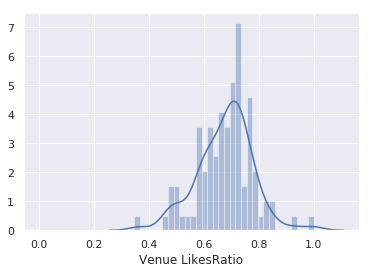

In [59]:
# instead of the Rating, I'm substituting the more-straightforward LikesRatio
# determining distribution of venues' "Likes" / "Signals" (aka number of ratings)
bins = np.linspace(0,venue_demo_prox['Venue LikesRatio'].max(), 50)
sns.set();

sns.distplot(venue_demo_prox['Venue LikesRatio'], bins=bins)

venue_demo_prox['Venue LikesRatio'].describe()

LikesRatio: Distribution skews to the left (mean < median) but unimodal and closer to being normal than either pure Likes or Rating; this seems more promising to use for modeling

#### Determing features

In [116]:
# convert subpopulation counts into proportions
age_demos_df['00-17'] = age_demos_df['00-17'] / age_demos_df['Total:ALL']
age_demos_df['18-34'] = age_demos_df['18-34'] / age_demos_df['Total:ALL']
age_demos_df['35-64'] = age_demos_df['35-64'] / age_demos_df['Total:ALL']
age_demos_df['65-99'] = age_demos_df['65-99'] / age_demos_df['Total:ALL']

race_demos_df['Total:Asian'] = race_demos_df['Total:Asian'] / race_demos_df['Total:ALL']
race_demos_df['Total:Black'] = race_demos_df['Total:Black'] / race_demos_df['Total:ALL']
race_demos_df['Total:Hisp'] = race_demos_df['Total:Hisp'] / race_demos_df['Total:ALL']
race_demos_df['Total:Other'] = race_demos_df['Total:Other'] / race_demos_df['Total:ALL']
race_demos_df['Total:White'] = race_demos_df['Total:White'] / race_demos_df['Total:ALL']



/home/b/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


,Venue LikesRatio,00-17,18-34,35-64,65-99
Venue LikesRatio,1.000000,0.250335,0.222965,-0.249119,-0.310518
00-17,0.250335,1.000000,0.198473,-0.571542,-0.520671
18-34,0.222965,0.198473,1.000000,-0.883632,-0.899583
35-64,-0.249119,-0.571542,-0.883632,1.000000,0.873987
65-99,-0.310518,-0.520671,-0.899583,0.873987,1.000000


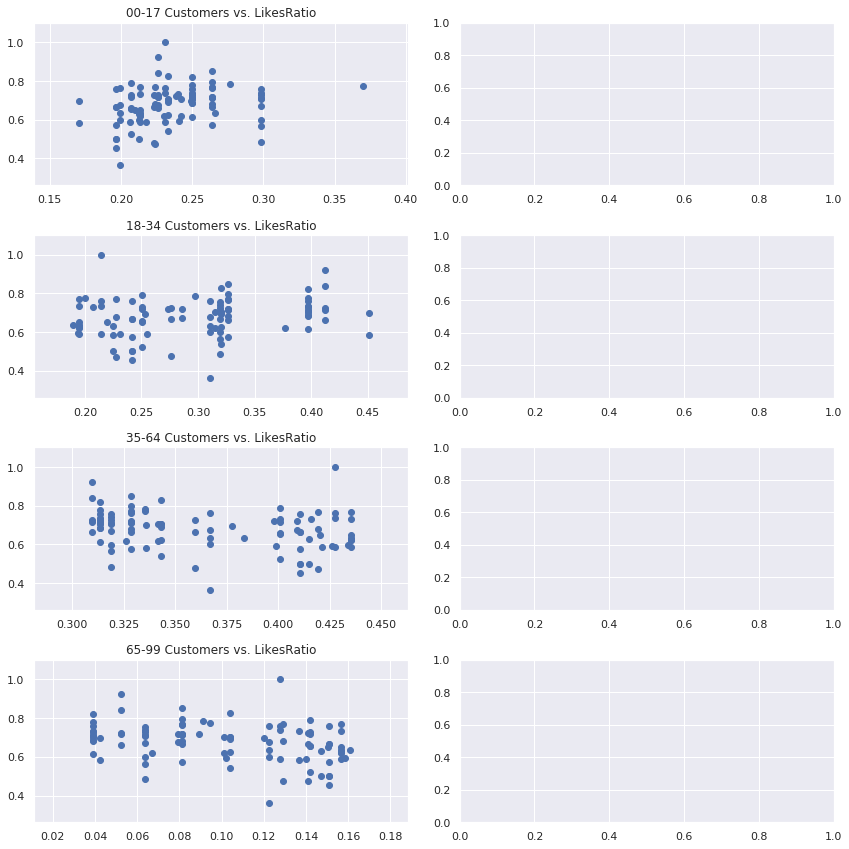

In [559]:
# checking relationships between each possible age-bracket and LikesRatio
fig, axes = plt.subplots(nrows=4, ncols=2)

#estimated number of possible customers per age bracket
axes[0,0].scatter(age_demos_df['00-17'], age_demos_df['Venue LikesRatio'])
axes[0,0].set_title("00-17 Customers vs. LikesRatio")

axes[1,0].scatter(age_demos_df['18-34'], age_demos_df['Venue LikesRatio'])
axes[1,0].set_title("18-34 Customers vs. LikesRatio")

axes[2,0].scatter(age_demos_df['35-64'], age_demos_df['Venue LikesRatio'])
axes[2,0].set_title("35-64 Customers vs. LikesRatio")

axes[3,0].scatter(age_demos_df['65-99'], age_demos_df['Venue LikesRatio'])
axes[3,0].set_title("65-99 Customers vs. LikesRatio")


#concentration factor per age bracket
#axes[0,1].scatter(age_demos_df['00-17 conc'], age_demos_df['Venue LikesRatio'])
#axes[0,1].set_title("00-17 Concentration vs. LikesRatio")

#axes[1,1].scatter(age_demos_df['18-34 conc'], age_demos_df['Venue LikesRatio'])
#axes[1,1].set_title("18-34 Concentration vs. LikesRatio")

#axes[2,1].scatter(age_demos_df['35-64 conc'], age_demos_df['Venue LikesRatio'])
#axes[2,1].set_title("35-64 Concentration vs. LikesRatio")

#axes[3,1].scatter(age_demos_df['65-99 conc'], age_demos_df['Venue LikesRatio'])
#axes[3,1].set_title("65-99 Concentration vs. LikesRatio")


#estimated "concentrated customers" per age bracket
#axes[0,2].scatter((age_demos_df['00-17 conc']+1)*age_demos_df['00-17'], age_demos_df['Venue LikesRatio'])
#axes[0,2].set_title("00-17 Conc'd Customers vs. LikesRatio")

#axes[1,2].scatter((age_demos_df['18-34 conc']+1)*age_demos_df['18-34'], age_demos_df['Venue LikesRatio'])
#axes[1,2].set_title("18-34 Conc'd Customers vs. LikesRatio")

#axes[2,2].scatter((age_demos_df['35-64 conc']+1)*age_demos_df['35-64'], age_demos_df['Venue LikesRatio'])
#axes[2,2].set_title("35-64 Conc'd Customers vs. LikesRatio")

#axes[3,2].scatter((age_demos_df['65-99 conc']+1)*age_demos_df['65-99'], age_demos_df['Venue LikesRatio'])
#axes[3,2].set_title("65-99 Conc'd Customers vs. LikesRatio")


fig.set_size_inches(w=12,h=12)
fig.tight_layout(pad=1.20) #more whitespace between plots so titles are visible
fig.show()

age_demos_df[['Venue LikesRatio', '00-17', '18-34', '35-64', '65-99']].corr()

/home/b/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


,Venue LikesRatio,Total:Asian,Total:Black,Total:Hisp,Total:Other,Total:White
Venue LikesRatio,1.000000,0.047817,0.158755,0.334659,-0.139533,-0.107488
Total:Asian,0.047817,1.000000,-0.242870,-0.227612,-0.312921,-0.058640
Total:Black,0.158755,-0.242870,1.000000,0.599696,0.405077,-0.909079
Total:Hisp,0.334659,-0.227612,0.599696,1.000000,-0.271090,-0.340088
Total:Other,-0.139533,-0.312921,0.405077,-0.271090,1.000000,-0.571569
Total:White,-0.107488,-0.058640,-0.909079,-0.340088,-0.571569,1.000000


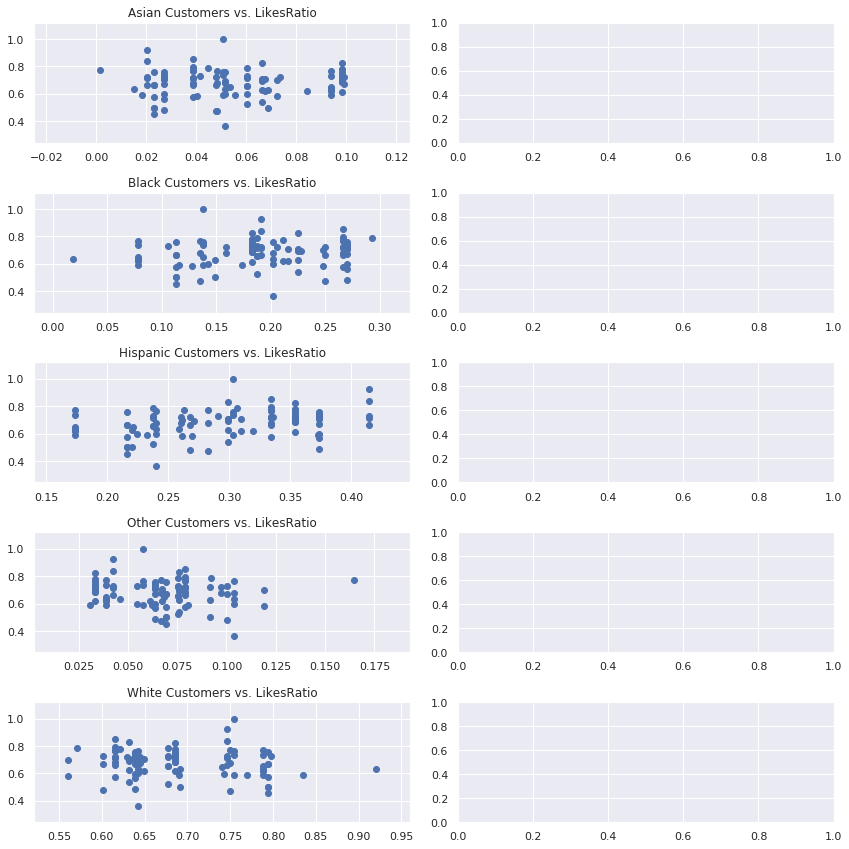

In [560]:
# checking relationships between each possible racial/ethnic group and LikesRatio
fig, axes = plt.subplots(nrows=5, ncols=2)

#estimated number of possible customers per group
axes[0,0].scatter(race_demos_df['Total:Asian'], race_demos_df['Venue LikesRatio'])
axes[0,0].set_title("Asian Customers vs. LikesRatio")

axes[1,0].scatter(race_demos_df['Total:Black'], race_demos_df['Venue LikesRatio'])
axes[1,0].set_title("Black Customers vs. LikesRatio")

axes[2,0].scatter(race_demos_df['Total:Hisp'], race_demos_df['Venue LikesRatio'])
axes[2,0].set_title("Hispanic Customers vs. LikesRatio")

axes[3,0].scatter(race_demos_df['Total:Other'], race_demos_df['Venue LikesRatio'])
axes[3,0].set_title("Other Customers vs. LikesRatio")

axes[4,0].scatter(race_demos_df['Total:White'], race_demos_df['Venue LikesRatio'])
axes[4,0].set_title("White Customers vs. LikesRatio")

#concentration factor per group
#axes[0,1].scatter(race_demos_df['Total:Asian conc'], race_demos_df['Venue LikesRatio'])
#axes[0,1].set_title("Asian Concentration vs. LikesRatio")

#axes[1,1].scatter(race_demos_df['Total:Black conc'], race_demos_df['Venue LikesRatio'])
#axes[1,1].set_title("Black Concentration vs. LikesRatio")

#axes[2,1].scatter(race_demos_df['Total:Hisp conc'], race_demos_df['Venue LikesRatio'])
#axes[2,1].set_title("Hispanic Concentration vs. LikesRatio")

#axes[3,1].scatter(race_demos_df['Total:Other conc'], race_demos_df['Venue LikesRatio'])
#axes[3,1].set_title("Other Concentration vs. LikesRatio")

#axes[4,1].scatter(race_demos_df['Total:White conc'], race_demos_df['Venue LikesRatio'])
#axes[4,1].set_title("White Concentration vs. LikesRatio")

#estimated "concentrated customers" per group
#axes[0,2].scatter((race_demos_df['Total:Asian conc']+1)*race_demos_df['Total:Asian'], race_demos_df['Venue LikesRatio'])
#axes[0,2].set_title("Asian Conc'd Customers vs. LikesRatio")

#axes[1,2].scatter((race_demos_df['Total:Black conc']+1)*race_demos_df['Total:Black'], race_demos_df['Venue LikesRatio'])
#axes[1,2].set_title("Black Conc'd Customers vs. LikesRatio")

#axes[2,2].scatter((race_demos_df['Total:Hisp conc']+1)*race_demos_df['Total:Hisp'], race_demos_df['Venue LikesRatio'])
#axes[2,2].set_title("Hispanic Conc'd Customers vs. LikesRatio")

#axes[3,2].scatter((race_demos_df['Total:Other conc']+1)*race_demos_df['Total:Other'], race_demos_df['Venue LikesRatio'])
#axes[3,2].set_title("Other Conc'd Customers vs. LikesRatio")

#axes[4,2].scatter((race_demos_df['Total:White conc']+1)*race_demos_df['Total:White'], race_demos_df['Venue LikesRatio'])
#axes[4,2].set_title("White Conc'd Customers vs. LikesRatio")

fig.set_size_inches(w=12,h=12)
fig.tight_layout(pad=1.20) #more whitespace between plots so titles are visible
fig.show()

race_demos_df[['Venue LikesRatio', 'Total:Asian', 'Total:Black', 'Total:Hisp', 'Total:Other', 'Total:White']].corr()

No real promising correlations are popping out in terms of age bracket or racial group...

Let's look at each venue's competition?

In [558]:
venues_for_crossing = venue_demo_prox.filter(regex="^(((Venue)(.)*))$")
venues_for_crossing.reset_index(inplace=True)
venues_for_crossing['Key'] = 0
venue_competition = venues_for_crossing.merge(venues_for_crossing, how='outer', on='Key')
venue_competition = venue_competition[venue_competition['index_x'] != venue_competition['index_y']]
venue_competition.reset_index(inplace=True, drop=True)
venue_competition.drop('Key', axis=1, inplace=True)

for ind in np.arange(venue_competition.shape[0]):
    distance = dist_latlong(venue_competition.at[ind, 'Venue_Latitude_x'], venue_competition.at[ind, 'Venue_Longitude_x'], 
                            venue_competition.at[ind, 'Venue_Latitude_y'], venue_competition.at[ind, 'Venue_Longitude_y'],)
    venue_competition.at[ind, 'dist_apart'] = distance
    
venue_competition['SameCat'] = (venue_competition['Venue_Category_x'] == venue_competition['Venue_Category_y'])

#print(venue_competition.head())

venue_competition = venue_competition[(venue_competition['dist_apart'] < radius_margin * search_radius) | venue_competition['SameCat'] == True]

#print(venue_competition.shape)
#venue_competition.head()

venue_comp_pivot = venue_competition.pivot_table(values = 'Venue LikesRatio_y', aggfunc = 'mean', index = ['index_x', 'Venue_x', 'Venue LikesRatio_x', 'Venue_ID_x'])
venue_comp_pivot.reset_index(inplace=True)
venue_comp_pivot.set_index('index_x', inplace=True)
print(venue_comp_pivot.shape)
venue_comp_pivot.head()

/home/b/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(96, 4)


,Venue_x,Venue LikesRatio_x,Venue_ID_x,Venue LikesRatio_y
index_x,,,,
0,Acropolis Greek Taverna,0.675159,4b184c0ff964a5206ed023e3,0.672951
1,Anthony's Coal Fired Pizza,0.664430,4b23d54df964a520c25a24e3,0.698501
2,Babe's Pizza,0.596491,4b7876ebf964a52026d02ee3,0.642998
3,Bahama Breeze,0.716216,5023ffe7e4b09c2bc13aa810,0.698349
4,Beef 'O' Brady's,0.633333,4bcb42a7b6c49c7463ca9191,0.646516


,Venue LikesRatio_x,Venue LikesRatio_y
Venue LikesRatio_x,1.000000,0.252085
Venue LikesRatio_y,0.252085,1.000000


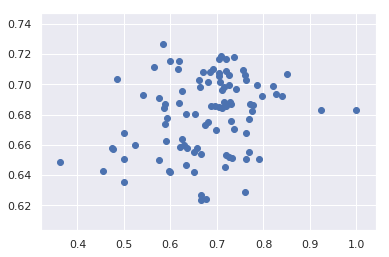

In [556]:
plt.scatter(venue_comp_pivot['Venue LikesRatio_x'], venue_comp_pivot['Venue LikesRatio_y'])
venue_comp_pivot[['Venue LikesRatio_x', 'Venue LikesRatio_y']].corr()

Not much better, let's revisit the clusters that were prepared earlier

/home/b/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


,Venue LikesRatio,blue Cluster,cyan Cluster,green Cluster,red Cluster
Venue LikesRatio,1.000000,0.092494,0.274983,-0.136126,-0.249542
blue Cluster,0.092494,1.000000,0.514373,-0.583997,-0.461265
cyan Cluster,0.274983,0.514373,1.000000,-0.535036,-0.635961
green Cluster,-0.136126,-0.583997,-0.535036,1.000000,0.347968
red Cluster,-0.249542,-0.461265,-0.635961,0.347968,1.000000


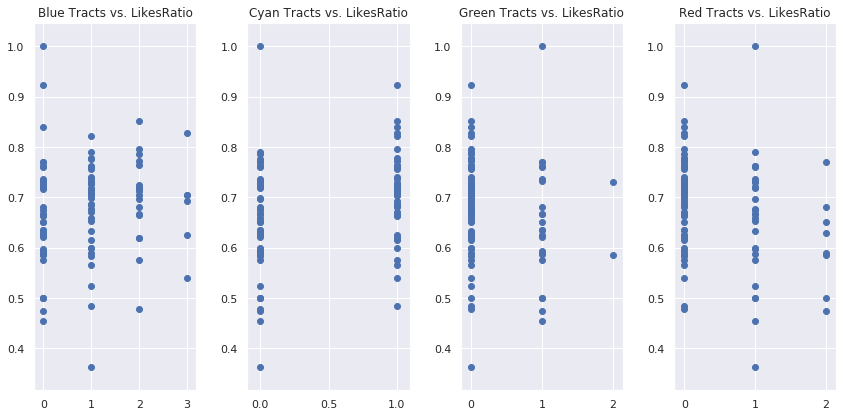

In [557]:
# checking relationships between each possible racial/ethnic group and LikesRatio
fig, axes = plt.subplots(nrows=1, ncols=4)

#estimated number of possible customers per group
axes[0].scatter(venue_demo_prox['blue Cluster'], venue_demo_prox['Venue LikesRatio'])
axes[0].set_title("Blue Tracts vs. LikesRatio")

axes[1].scatter(venue_demo_prox['cyan Cluster'], venue_demo_prox['Venue LikesRatio'])
axes[1].set_title("Cyan Tracts vs. LikesRatio")

axes[2].scatter(venue_demo_prox['green Cluster'], venue_demo_prox['Venue LikesRatio'])
axes[2].set_title("Green Tracts vs. LikesRatio")

axes[3].scatter(venue_demo_prox['red Cluster'], venue_demo_prox['Venue LikesRatio'])
axes[3].set_title("Red Tracts vs. LikesRatio")

fig.set_size_inches(w=12,h=6)
fig.tight_layout(pad=1.20) #more whitespace between plots so titles are visible
fig.show()

venue_demo_prox[['Venue LikesRatio', 'blue Cluster', 'cyan Cluster', 'green Cluster', 'red Cluster']].corr()

Still not much, but maybe the combination of these sets of possible Features might result in something useful?

In [401]:
#use_df = venue_demo_prop.reset_index()
use_df = venue_demo_prox.reset_index()
#use_df = venue_mapping
#use_df = age_demos_df
#use_df = race_demos_df
#use_df = venue_comp_pivot

#use_df = venue_mapping.merge(age_demos_df, how='inner')
#use_df = use_df.merge(race_demos_df, how='inner')
use_df = use_df.merge(venue_cat_onehot.reset_index(), how='inner')
use_df.drop('index', axis=1, inplace=True)

#use_df = use_df.filter(regex="^(((Venue)(.)*)|((.)*( conc)))$") #keep only venue and conc columns
use_df = use_df.filter(regex="^((?!dist).)*$") #remove the distance column(s)
use_df = use_df.filter(regex="^((?!ALL).)*$") #remove the ALL columns
use_df = use_df.filter(regex="^(.(?!conc))*$") #remove the conc columns
use_df = use_df.filter(regex="^(.(?!Category))*$") #remove the 'Venue_Category' column
use_df = use_df.filter(regex="^(.(?!avg))*$") #remove the abbrev latitude and longitude columns
use_df = use_df.filter(regex="^(.(?!min))*$") #remove the abbrev latitude and longitude columns
use_df = use_df.filter(regex="^(.(?!max))*$") #remove the abbrev latitude and longitude columns
use_df = use_df.filter(regex="^(.(?!tude))*$") #remove the latitude and longitude columns
use_df = use_df.filter(regex="^(.(?!ID))*$") #remove the ID columns
#use_df = use_df.filter(regex="^(.(?!Likes))*$") #remove the Likes columns

#use_df['Venue Rating'] = use_df['Venue Rating'] / use_df['Venue Rating'].max()

print(use_df.shape)
use_df.head()

(96, 17)


,Venue,Venue Likes,Venue Rating,Venue Signals,Venue LikesRatio,Venue Price,blue Cluster,cyan Cluster,green Cluster,red Cluster,Cat:American,Cat:Asian,Cat:European,Cat:Fast,Cat:Joints,Cat:Latin,Cat:Other
0,Acropolis Greek Taverna,106.0,8.8,157.0,0.675159,2.0,0,0,0,1,0,0,1,0,0,0,0
1,Anthony's Coal Fired Pizza,99.0,9.0,149.0,0.664430,1.0,2,1,0,0,0,0,0,1,0,0,0
2,Babe's Pizza,34.0,8.8,57.0,0.596491,1.0,0,0,0,1,0,0,0,1,0,0,0
3,Bahama Breeze,159.0,8.6,222.0,0.716216,2.0,0,1,0,0,0,0,0,0,0,1,0
4,Beef 'O' Brady's,38.0,8.0,60.0,0.633333,2.0,1,0,0,1,1,0,0,0,0,0,0


In [402]:
use_df.columns

Index(['Venue', 'Venue Likes', 'Venue Rating', 'Venue Signals',
       'Venue LikesRatio', 'Venue Price', 'blue Cluster', 'cyan Cluster',
       'green Cluster', 'red Cluster', 'Cat:American', 'Cat:Asian',
       'Cat:European', 'Cat:Fast', 'Cat:Joints', 'Cat:Latin', 'Cat:Other'],
      dtype='object')

### Using machine learning to model key features for highest "likes ratio"

#### Standardize dataset

In [403]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaled_df = use_df.copy()
scaled_df = scaled_df.filter(regex="^(.*((LikesRatio)|(-)|(:)|(.*Cluster)).*)$")
scaler.fit(scaled_df)
scaled_df.head()

/home/b/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


,Venue LikesRatio,blue Cluster,cyan Cluster,green Cluster,red Cluster,Cat:American,Cat:Asian,Cat:European,Cat:Fast,Cat:Joints,Cat:Latin,Cat:Other
0,0.675159,0,0,0,1,0,0,1,0,0,0,0
1,0.664430,2,1,0,0,0,0,0,1,0,0,0
2,0.596491,0,0,0,1,0,0,0,1,0,0,0
3,0.716216,0,1,0,0,0,0,0,0,0,1,0
4,0.633333,1,0,0,1,1,0,0,0,0,0,0


In [404]:
#corr_df = scaled_df[[
                  #'Venue LikesRatio'
                  #, 'Venue Rating'
                  #'Venue Rating_x', 'Venue Rating_y', 'dist_apart'
                  #, 'Venue_Latitude', 'Venue_Longitude'
                  #, 'Cat:American', 'Cat:Asian', 'Cat:European', 'Cat:Fast', 'Cat:Joints', 'Cat:Latin', 'Cat:Other'
                  #, '00-17', '18-34', '35-64', '65-99' 
                  #, 'Total:Asian', 'Total:Black', 'Total:Hisp', 'Total:Other', 'Total:White'
                 #]]
                
corr_df = scaled_df #.filter(like = 'White', axis=1)
#corr_df['Venue LikesRatio'] = scaled_df['Venue LikesRatio']

corr = corr_df.corr()['Venue LikesRatio'].abs()

print(corr.sort_values(ascending=False)[0:20])

#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
#cax = ax.matshow(corr,cmap='coolwarm', vmin=0, vmax=1)
#fig.colorbar(cax)
#ticks = np.arange(0,len(corr_df.columns),1)
#ax.set_xticks(ticks)
#plt.xticks(rotation=90)
#ax.set_yticks(ticks)
#ax.set_xticklabels(corr_df.columns)
#ax.set_yticklabels(corr_df.columns)
#plt.show()

# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3.

Venue LikesRatio    1.000000
cyan Cluster        0.274983
red Cluster         0.249542
Cat:Joints          0.191521
green Cluster       0.136126
Cat:American        0.115443
blue Cluster        0.092494
Cat:Asian           0.089786
Cat:Latin           0.064120
Cat:Fast            0.063486
Cat:European        0.050881
Cat:Other           0.049950
Name: Venue LikesRatio, dtype: float64


#### Choosing variables (ind = Feature, dep = y)

In [405]:
venue_cols = scaled_df.filter(regex="^((Venue)(.)*)$").columns.tolist()
rating_col = len(venue_cols)
first_ft_col = rating_col
col_for_ft = scaled_df.columns[first_ft_col:].tolist()

Feature = scaled_df[col_for_ft]
#Feature = pd.concat([Feature, pd.get_dummies(use_df['Venue_Category'])], axis=1)
#y_likes = use_df['Venue Likes'].values
#y_rating = use_df['Venue Rating'].values #> 8.2
y_ratio = scaled_df['Venue LikesRatio']

y_class = np.where(y_ratio > y_ratio.median(), "Good", "Bad")

print(col_for_ft)
print(y_class)

Feature_std = pd.DataFrame(preprocessing.StandardScaler().fit(Feature).transform(Feature), columns = col_for_ft)

['blue Cluster', 'cyan Cluster', 'green Cluster', 'red Cluster', 'Cat:American', 'Cat:Asian', 'Cat:European', 'Cat:Fast', 'Cat:Joints', 'Cat:Latin', 'Cat:Other']
['Bad' 'Bad' 'Bad' 'Good' 'Bad' 'Good' 'Good' 'Bad' 'Bad' 'Bad' 'Bad'
 'Good' 'Good' 'Good' 'Good' 'Good' 'Bad' 'Bad' 'Good' 'Good' 'Good' 'Bad'
 'Good' 'Bad' 'Bad' 'Bad' 'Bad' 'Good' 'Good' 'Good' 'Bad' 'Good' 'Good'
 'Good' 'Good' 'Good' 'Bad' 'Bad' 'Good' 'Good' 'Bad' 'Bad' 'Bad' 'Good'
 'Good' 'Good' 'Good' 'Good' 'Bad' 'Bad' 'Good' 'Good' 'Good' 'Good' 'Bad'
 'Good' 'Bad' 'Bad' 'Good' 'Good' 'Good' 'Good' 'Bad' 'Bad' 'Bad' 'Bad'
 'Good' 'Bad' 'Good' 'Bad' 'Good' 'Bad' 'Bad' 'Good' 'Good' 'Good' 'Bad'
 'Good' 'Bad' 'Good' 'Bad' 'Good' 'Good' 'Bad' 'Bad' 'Bad' 'Bad' 'Bad'
 'Good' 'Good' 'Bad' 'Bad' 'Bad' 'Bad' 'Bad' 'Bad']


/home/b/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/b/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.


In [521]:
reg_x_train, reg_x_test, reg_y_train, reg_y_test = train_test_split(Feature, pd.DataFrame(y_ratio), test_size=0.3)

multi_lin = linear_model.LinearRegression()
x_tr_array = np.asanyarray(reg_x_train)
y_tr_array = np.asanyarray(reg_y_train)
multi_lin.fit (x_tr_array, y_tr_array)
# The coefficients
print ('Coefficients: ', multi_lin.coef_)

y_hat_multi = multi_lin.predict(reg_x_test)
x_ts_array = np.asanyarray(reg_x_test)
y_ts_array = np.asanyarray(reg_y_test)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat_multi - y_ts_array) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % multi_lin.score(x_ts_array, y_ts_array))

Coefficients:  [[-0.01  0.03 -0.02 -0.03  0.   -0.03 -0.02  0.01  0.03  0.02 -0.01]]
Residual sum of squares: 0.02
Variance score: -0.04


In [407]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(b=None)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Logistic Regression

In [408]:
#not using KFold for cross-validation b/c venues may not be sorted randomly
#adjacent records might be inherently similar and introduce bias into model
#attempting to implement a randomized iterative splitting instead

log_eq_it = pd.DataFrame(columns = col_for_ft)
log_eq_it['Intercept'] = ''

print(log_eq_it)

Empty DataFrame
Columns: [blue Cluster, cyan Cluster, green Cluster, red Cluster, Cat:American, Cat:Asian, Cat:European, Cat:Fast, Cat:Joints, Cat:Latin, Cat:Other, Intercept]
Index: []


In [510]:
#trying a version of K-fold that includes random shuffling instead

LR_cv = LogisticRegression(C=0.01, solver='liblinear')
rs = ShuffleSplit(n_splits = 1000, test_size = 0.30)
scores = cross_val_score(LR_cv, Feature, y_class, cv=rs)
print(str(scores.mean()) + " +/- " + str(scores.std()))

0.6164827586206897 +/- 0.08673710055999849


#### Decision Tree

Train set: (67, 11) (67,)
Test set: (29, 11) (29,)
['Bad' 'Bad' 'Bad' 'Good' 'Good']
['Bad' 'Bad' 'Good' 'Good' 'Good']
DecisionTrees's Accuracy:  0.5172413793103449
Confusion matrix, without normalization
[[7 7]
 [7 8]]


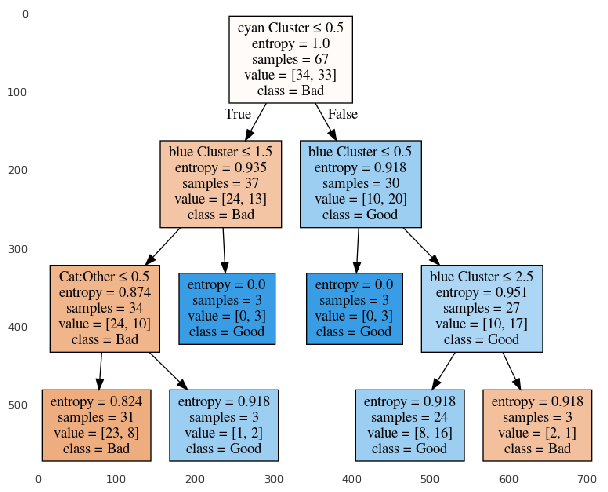

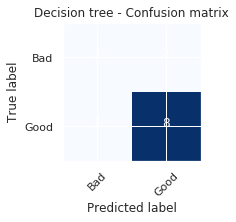

In [508]:
X_trainset_dt, X_testset_dt, y_trainset_dt, y_testset_dt = train_test_split(Feature, y_class, test_size=0.3)
#using Feature instead of X b/c normalized data is less meaningful in the resulting graph and doesn't appear to impact the result
print ('Train set:', X_trainset_dt.shape,  y_trainset_dt.shape)
print ('Test set:', X_testset_dt.shape,  y_testset_dt.shape)

venueTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
venueTree.fit(X_trainset_dt,y_trainset_dt)
predTree = venueTree.predict(X_testset_dt)
print (predTree [0:5])
print (y_testset_dt [0:5])

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset_dt, predTree))
dot_data = StringIO()
filename = "ratingTree.png"
featureNames = Feature.columns
targetNames = np.unique(y).tolist()
out=tree.export_graphviz(venueTree, feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset_dt), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(10, 20))
plt.grid(b=None)
plt.imshow(img,interpolation='nearest')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset_dt, predTree, labels=np.unique(y_testset_dt))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(3, 6))
plt.grid(b=None)
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_testset_dt),normalize= False,  title='Decision tree - Confusion matrix')

#### Support Vector Machine

In [435]:
from sklearn import svm

X_trainset_svm, X_testset_svm, y_trainset_svm, y_testset_svm = train_test_split(Feature, y_class, test_size=0.3)

venue_svm = svm.SVC(kernel='rbf', gamma = 'auto')
venue_svm.fit(X_trainset_svm, y_trainset_svm) 
yhat_svm = venue_svm.predict(X_testset_svm)
#yhat_svm [0:5]

rs = ShuffleSplit(n_splits = 1000, test_size = 0.30)
scores = cross_val_score(venue_svm, Feature, y, cv=rs)
print(str(scores.mean()) + " +/- " + str(scores.std()))

#print("Jaccard score: " + str(jaccard_similarity_score(y_testset_svm, yhat_svm)) )
#print("Accuracy: " + str(metrics.accuracy_score(y_testset_svm, yhat_svm)) )
#print("F1 score: " + str(f1_score(y_testset_svm, yhat_svm, average='weighted') ) )

0.6302413793103449 +/- 0.07790563363887998


#### Building table representing all feasible "venues" in terms of the Features defined above 

In [441]:
Feature.describe()

,blue Cluster,cyan Cluster,green Cluster,red Cluster,Cat:American,Cat:Asian,Cat:European,Cat:Fast,Cat:Joints,Cat:Latin,Cat:Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.927083,0.468750,0.281250,0.458333,0.187500,0.177083,0.052083,0.125000,0.166667,0.145833,0.145833
std,0.908959,0.501642,0.496368,0.647532,0.392361,0.383743,0.223361,0.332455,0.374634,0.354792,0.354792
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [478]:
feasible_venues = pd.DataFrame()

for bClusVal in np.arange(Feature['blue Cluster'].max()+1):
    for cClusVal in np.arange(Feature['cyan Cluster'].max()+1):
        for gClusVal in np.arange(Feature['green Cluster'].max()+1):
            for rClusVal in np.arange(Feature['red Cluster'].max()+1):
                for amOneHot in np.arange(2):
                    for asOneHot in np.arange(2):
                        for euOneHot in np.arange(2):
                            for fsOneHot in np.arange(2):
                                for jtOneHot in np.arange(2):
                                    for ltOneHot in np.arange(2):
                                        for otOneHot in np.arange(2):
                                            feasible_venues = feasible_venues.append(pd.Series((  bClusVal, cClusVal, gClusVal, rClusVal, 
                                                                                                  amOneHot, asOneHot, euOneHot, fsOneHot, 
                                                                                                  jtOneHot, ltOneHot, otOneHot
                                                                                                )
                                                                                               ), ignore_index=True
                                                                                    )

feasible_venues.columns = Feature.columns

In [484]:
print(feasible_venues.shape)
# venues can only be one cuisine category, so filter out any rows where no cuisine or more than one cuisine were marked 1
feasible_venues = feasible_venues[feasible_venues[['Cat:American', 'Cat:Asian', 'Cat:European', 'Cat:Fast', 'Cat:Joints', 'Cat:Latin', 'Cat:Other']].sum(axis=1) == 1]
print(feasible_venues.shape)
#feasible_venues.describe()

(9216, 11)
(504, 11)


In [498]:
svm_predictions = feasible_venues.copy()
svm_predictions['svmRatio'] = venue_svm.predict(np.array(feasible_venues))
svm_predictions.head()

,blue Cluster,cyan Cluster,green Cluster,red Cluster,Cat:American,Cat:Asian,Cat:European,Cat:Fast,Cat:Joints,Cat:Latin,Cat:Other,svmRatio
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Bad
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Bad
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Bad
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Bad
16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Bad


In [501]:
svm_predictions['Cuisine'] = svm_predictions[['Cat:American', 'Cat:Asian', 'Cat:European', 'Cat:Fast', 'Cat:Joints', 'Cat:Latin', 'Cat:Other']].idxmax(axis=1)
svm_predictions = svm_predictions.filter(regex="^((?!Cat).)*$")

In [503]:
svm_predictions.head()

,blue Cluster,cyan Cluster,green Cluster,red Cluster,svmRatio,Cuisine
1,0.0,0.0,0.0,0.0,Bad,Cat:Other
2,0.0,0.0,0.0,0.0,Bad,Cat:Latin
4,0.0,0.0,0.0,0.0,Bad,Cat:Joints
8,0.0,0.0,0.0,0.0,Bad,Cat:Fast
16,0.0,0.0,0.0,0.0,Bad,Cat:European


In [509]:
svm_predictions.pivot_table(index=['Cuisine', 'svmRatio'], values=['blue Cluster', 'cyan Cluster', 'green Cluster', 'red Cluster'], aggfunc='mean')

blue Cluster  cyan Cluster  green Cluster  red Cluster
Cuisine      svmRatio                                                        
Cat:American Bad           1.065217      0.326087       1.108696     1.217391
             Good          2.269231      0.807692       0.807692     0.615385
Cat:Asian    Bad           1.440678      0.389831       1.084746     1.169492
             Good          1.769231      1.000000       0.615385     0.230769
Cat:European Bad           1.250000      0.365385       1.115385     1.230769
             Good          2.150000      0.850000       0.700000     0.400000
Cat:Fast     Bad           1.250000      0.312500       1.166667     1.229167
             Good          2.000000      0.875000       0.666667     0.541667
Cat:Joints   Bad           1.030303      0.212121       1.181818     1.393939
             Good          1.897436      0.743590       0.846154     0.666667
Cat:Latin    Bad           1.027778      0.250000       1.222222     1.333333
             Good          1.972222      0.750000       0.777778     0.666667
Cat:Other    Bad           1.239130      0.282609       1.152174     1.239130
             Good          1.961538      0.884615       0.730769     0.576923

## Other analysis, discarded

most_proximal = []

for row in np.arange(use_df.shape[0]):
    temp_row = pd.DataFrame(use_df.iloc[row, 7:])
    #print(temp_row)
    temp_row.iloc[:,0] = pd.to_numeric(temp_row.iloc[:,0])
    max_cat = temp_row.idxmax()[row]
    most_proximal.append([use_df['Venue_ID'][row], use_df['Venue'][row], str(max_cat), use_df.iloc[row, 7:].max().round(8)])
    
most_prox_df = pd.DataFrame(data = most_proximal, columns = ['Venue_ID', 'Venue', 'Demo', 'Proximity']).sort_values('Proximity', ascending=False)
#most_prox_df = pd.DataFrame(data = most_proximal, columns = ['Venue_ID', 'Venue', 'Demo', 'Proximity']).sort_values('Demo', ascending=False)

most_prox_df.head()


# create map
map_most_prox = folium.Map(location=[latitude, longitude], zoom_start=12)

n_demos = most_prox_df['Demo'].nunique()

demo_ning = most_prox_df['Demo'].unique().tolist()

# set color scheme for the clusters
x = np.arange(n_demos)
ys = [i + x + (i*x)**2 for i in range(n_demos)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

venue_w_prox = venue_mapping.merge(most_prox_df[['Venue_ID', 'Demo', 'Proximity']], on='Venue_ID')

#venue_w_prox.head()


# add markers to the map
markers_colors = []
for lat, lon, poi, demog, cats in zip(   venue_w_prox['Venue_Latitude'], venue_w_prox['Venue_Longitude'], venue_w_prox['Venue'], venue_w_prox['Demo'], venue_w_prox['Venue_Category']):
    html =  """Venue: {venue}<br>Demo: {demo}<br>Cat: {cat}"""
    iframe = folium.IFrame(html=html.format(venue = str(poi), demo = str(demog), cat = str(cats)), width=300, height=100)
    
    #label = folium.Popup("Venue: " + str(poi) + " |" + " Demo: " + str(demog) + " |" + " Category: " + str(cats), parse_html=True)
    label = folium.Popup(iframe)
    
    folium.CircleMarker(
                        [lat, lon], radius=5,
                        popup=label, color=rainbow[demo_ning.index(demog)],
                        fill=True, fill_color=rainbow[demo_ning.index(demog)], fill_opacity=0.7
                        ).add_to(map_most_prox)
       
map_most_prox